In [1]:
import itertools

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Tuple, List
from multiprocessing import Pool
import math
rng = np.random.default_rng(12345)

In [2]:
CONTROL_TIMESTEP_DAYS = 10
NUM_CONTROL_STEPS = 4
# corn prices are measured in USD / 56 lbs at 15.5% moisture (by mass)
CORN_PRICE_USD_PER_G_GRAIN = 4.80 / (1 - 0.155) / 25401.2
N_PRICE_USD_PER_G = 0.0011
N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 = 1200
NNI_TO_RELATIVE_YIELD_CORRELATION = 1.17
MAX_BIOMASS_G_DRY_MASS_PER_M2 = 3000

INORGANIC_N_MODEL_DT_DAYS = 1.0 / 24.0 * 2.0 / 6.0

NUM_DAYS_TOTAL = CONTROL_TIMESTEP_DAYS * NUM_CONTROL_STEPS
SOIL_POROSITY = 0.35 # Porporato had 0.4
SOIL_DEPTH_MM = 300 # Porporato had 800
SOIL_VOID_SPACE_MM = SOIL_POROSITY * SOIL_DEPTH_MM
HYGROSCOPIC_POINT = 0.04 # Porporato had 0.02
WILTING_POINT = 0.05 # Porporato had 0.065
MAX_MOISTURE_WITH_CLOSED_STOMATA = 0.16 # Porporato had 0.17
FIELD_CAPACITY = 0.35 # Porporato had 0.3
MAXIMUM_EVAPORATION_RATE_MM_PER_DAY = 0.1 # Porporato had 1.0
MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY = 3.6 # Porporato had 3.5
SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY = 1000 # Porporato had 1100
PORE_SIZE_DISTRIBUTION_INDEX = 4.05 # 4.05 for porporato conditions
BETA = 4.0 * PORE_SIZE_DISTRIBUTION_INDEX + 4.0
ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY = 1.5
PROPORTION_BIOMASS_DYING_PER_DAY = 0.0085
PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.000065
PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.0000025
MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY = 1.0
MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY = 1.0
PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY = 0.006 # porporato had 0.6
DISSOLVED_FRACTION_AMMONIUM = 0.05
DISSOLVED_FRACTION_NITRATE = 1.0 # https://link.springer.com/chapter/10.1007/978-94-007-0394-0_23/tables/4 has 0.1 but that can't be right
RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 0.6
NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 1 - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON
MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER = 0.25
ADDED_RESIDUE_CN_RATIO = 58
BIOMASS_CN_RATIO = 11.5
HUMUS_CN_RATIO = 22 # porporato had 22
EXCESS_BIO_NITROGEN_PER_HUMUS_CARBON_DECOMPOSED = 1 / HUMUS_CN_RATIO - NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON / BIOMASS_CN_RATIO
# PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.2
# PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.5
PLANT_BIOMASS_G_DRY_MASS_PER_M2 = 600 # roughly 17L stage
DIFFUSION_COEFFICIENT_MM_PER_DAY = 100 # possibly should be 100 ? Porporato has 0.1 meters/day
DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT = 1.5 # Porporato had 3
RAIN_EXISTENCE_RATE = 0.3 # porporato had 0.23
RAIN_MEAN_DEPTH_MM = 15.5 # porporato had 11
LEACHING_CONCENTRATION_LIMIT_MG_PER_LITER = 10
LEACHING_VIOLATION_PENALTY_USD_PER_M2 = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN
FORECAST_LOOKAHEAD_DAYS = 3
PROBABILITY_OF_CLEAR_FORECAST = (1 - RAIN_EXISTENCE_RATE) ** FORECAST_LOOKAHEAD_DAYS
PROBABILITY_OF_CLEAR_FORECAST

0.3429999999999999

In [3]:
f_d = np.vectorize(lambda s : s / FIELD_CAPACITY if s <= FIELD_CAPACITY else FIELD_CAPACITY / s)
f_n = np.vectorize(lambda s: s / FIELD_CAPACITY if s <= FIELD_CAPACITY else (1 - s)/(1- FIELD_CAPACITY))
# N_c (g/kg DM) = 3.40 * (W (Mg DM / ha))^-0.37
# N_c (g/ha) = 3.40 * (W (Mg DM/ha)) ^ (1 - 0.37)
biomass_g_per_m2_to_critical_nitrogen_gN_per_m2 = np.vectorize(lambda w: 0.187 * (w ** 0.63))
day_to_biomass_g_per_m2 = np.vectorize(lambda day: day / NUM_DAYS_TOTAL * MAX_BIOMASS_G_DRY_MASS_PER_M2 + 0.001)
day_to_plant_N_demand_gN_per_m3_per_day = np.vectorize(lambda day: 0.02565 * np.exp(-0.00095 * day_to_biomass_g_per_m2(day)) * MAX_BIOMASS_G_DRY_MASS_PER_M2 / NUM_DAYS_TOTAL / (SOIL_VOID_SPACE_MM / 1000.)) #MAX_BIOMASS_G_DRY_MASS_PER_M2 / NUM_DAYS_TOTAL is dW/dt

Text(0, 0.5, 'N demand (gN/m^3/day)')

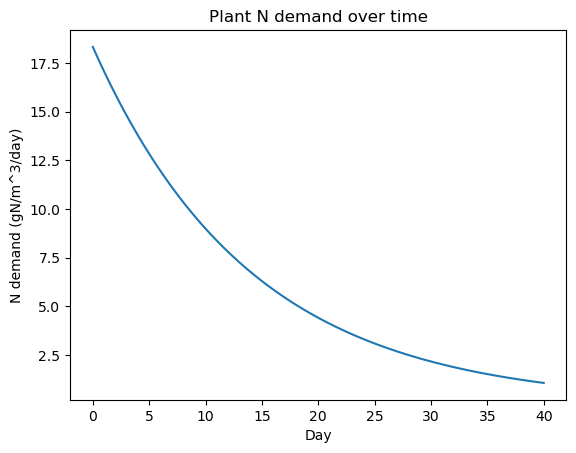

In [4]:
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, 100), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_DAYS_TOTAL, 100)))
plt.title("Plant N demand over time")
plt.xlabel("Day")
plt.ylabel("N demand (gN/m^3/day)")

In [5]:
print("N sufficient corn yield, in USD/m^2:", N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN)

N sufficient corn yield, in USD/m^2: 0.26835614251835654


# Water Modeling

In [6]:
def generate_rain(num_days: int):
    rain_events = rng.random(num_days) < RAIN_EXISTENCE_RATE
    rain_quantity_mm = rng.exponential(RAIN_MEAN_DEPTH_MM, num_days) * rain_events
    return rain_quantity_mm

def hydrology_model(initial_soil_moisture: float, rain_quantity_mm: npt.NDArray[np.float64]):
    num_days = len(rain_quantity_mm)

    # Define constants for computational efficiency
    LEAKAGE_COEFF = SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY / (np.exp(BETA * (1 - FIELD_CAPACITY)) - 1)
    TRANSPIRATION_SLOPE = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY / (MAX_MOISTURE_WITH_CLOSED_STOMATA - WILTING_POINT)

    # States and intermediate variables
    soil_moisture = np.zeros(num_days)
    infiltration_rate_mm_per_day = np.zeros(num_days)
    evaporation_rate_mm_per_day = np.zeros(num_days)
    transpiration_rate_mm_per_day = np.zeros(num_days)
    leakage_rate_mm_per_day = np.zeros(num_days)

    soil_moisture[0] = initial_soil_moisture

    for i in range(num_days):
        infiltration_rate_mm_per_day[i] = min(rain_quantity_mm[i], SOIL_VOID_SPACE_MM * (1 - soil_moisture[i]))

        # evaporation
        if soil_moisture[i] < HYGROSCOPIC_POINT:
            evaporation_rate_mm_per_day[i] = 0
        elif soil_moisture[i] <= WILTING_POINT:
            evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY * (soil_moisture[i] - HYGROSCOPIC_POINT)
        else:
            evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY

        # Transpiration
        if soil_moisture[i] <= WILTING_POINT:
            transpiration_rate_mm_per_day[i] = 0
        elif soil_moisture[i] <= MAX_MOISTURE_WITH_CLOSED_STOMATA:
            transpiration_rate_mm_per_day[i] = TRANSPIRATION_SLOPE * (soil_moisture[i] - WILTING_POINT)
        else:
            transpiration_rate_mm_per_day[i] = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY

        # leakage/percolation
        leakage_rate_mm_per_day[i] = LEAKAGE_COEFF * (np.exp(BETA * (soil_moisture[i] - FIELD_CAPACITY)) - 1)
        if soil_moisture[i] - (leakage_rate_mm_per_day[i] / SOIL_VOID_SPACE_MM) < FIELD_CAPACITY: # make sure we don't drain more than is possible in very wet fields
            leakage_rate_mm_per_day[i] = max(0, (soil_moisture[i] - FIELD_CAPACITY) * SOIL_VOID_SPACE_MM)

        if i + 1 < num_days:
            soil_moisture[i+1] = soil_moisture[i] + (infiltration_rate_mm_per_day[i] - evaporation_rate_mm_per_day[i] - transpiration_rate_mm_per_day[i] - leakage_rate_mm_per_day[i]) / SOIL_VOID_SPACE_MM

    moisture_effect_on_decomposition_factor = f_d(soil_moisture)
    moisture_effect_on_nitrification_factor = f_n(soil_moisture)

    if any(infiltration_rate_mm_per_day < 0) or any(evaporation_rate_mm_per_day < 0) or any(transpiration_rate_mm_per_day < 0) or any(leakage_rate_mm_per_day < 0) or any(soil_moisture < 0) or any(soil_moisture > 1) or any(moisture_effect_on_decomposition_factor < 0) or any(moisture_effect_on_decomposition_factor > 1) or any(moisture_effect_on_nitrification_factor < 0) or any(moisture_effect_on_nitrification_factor > 1):
        print("Sanity check failed in hydrology model!")

    return soil_moisture, infiltration_rate_mm_per_day, evaporation_rate_mm_per_day, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor


# Soil Organic Matter Model

In [7]:
def soil_organic_model(initial_litter_carbon_gC_per_m3: float, initial_litter_nitrogen_gN_per_m3: float, initial_microbial_carbon_gC_per_m3: float, initial_humus_carbon_gC_per_m3: float, moisture_decomposition_factor: npt.NDArray[np.float64], added_residue_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], added_residue_carbon_gC_per_m3_per_day: npt.NDArray[np.float64]):
    array_length = len(moisture_decomposition_factor)
    assert len(added_residue_nitrogen_gN_per_m3_per_day) == array_length
    assert len(added_residue_carbon_gC_per_m3_per_day) == array_length

    # Set up arrays
    litter_cn_ratio_gC_per_gN = np.ndarray(array_length, np.float64)
    humified_fraction_of_decomposed_litter_carbon = np.ndarray(array_length, np.float64)
    microbified_fraction_of_decomposed_litter_carbon = np.ndarray(array_length, np.float64)
    litter_decomposition_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    humus_decomposition_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    microbial_death_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    litter_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)
    litter_nitrogen_gN_per_m3 = np.ndarray(array_length, np.float64)
    microbial_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)
    humus_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)

    # Assign initial values
    litter_carbon_gC_per_m3[0] = initial_litter_carbon_gC_per_m3
    litter_nitrogen_gN_per_m3[0] = initial_litter_nitrogen_gN_per_m3
    microbial_carbon_gC_per_m3[0] = initial_microbial_carbon_gC_per_m3
    humus_carbon_gC_per_m3[0] = initial_humus_carbon_gC_per_m3

    # Simulate
    for i in range(array_length):
        # intermediaries
        litter_cn_ratio_gC_per_gN[i] = litter_carbon_gC_per_m3[i] / litter_nitrogen_gN_per_m3[i]
        humified_fraction_of_decomposed_litter_carbon[i] = min(MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER, HUMUS_CN_RATIO / litter_cn_ratio_gC_per_gN[i])
        microbified_fraction_of_decomposed_litter_carbon[i] = NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON - humified_fraction_of_decomposed_litter_carbon[i]
        litter_decomposition_carbon_gC_per_m3_per_day[i] = PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY * moisture_decomposition_factor[i] * microbial_carbon_gC_per_m3[i] * litter_carbon_gC_per_m3[i]
        humus_decomposition_carbon_gC_per_m3_per_day[i] = PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY * moisture_decomposition_factor[i] * microbial_carbon_gC_per_m3[i] * humus_carbon_gC_per_m3[i]
        microbial_death_carbon_gC_per_m3_per_day[i] = PROPORTION_BIOMASS_DYING_PER_DAY * microbial_carbon_gC_per_m3[i]

        # states
        if i + 1 < array_length:
            litter_carbon_gC_per_m3[i + 1] = litter_carbon_gC_per_m3[i] + added_residue_carbon_gC_per_m3_per_day[i] + microbial_death_carbon_gC_per_m3_per_day[i] - litter_decomposition_carbon_gC_per_m3_per_day[i]
            litter_nitrogen_gN_per_m3[i + 1] = litter_nitrogen_gN_per_m3[i] + added_residue_nitrogen_gN_per_m3_per_day[i] + (microbial_death_carbon_gC_per_m3_per_day[i] / BIOMASS_CN_RATIO) - (litter_decomposition_carbon_gC_per_m3_per_day[i] / litter_cn_ratio_gC_per_gN[i])
            microbial_carbon_gC_per_m3[i + 1] = microbial_carbon_gC_per_m3[i] + microbified_fraction_of_decomposed_litter_carbon[i] * litter_decomposition_carbon_gC_per_m3_per_day[i] + NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON * humus_decomposition_carbon_gC_per_m3_per_day[i] - microbial_death_carbon_gC_per_m3_per_day[i]
            humus_carbon_gC_per_m3[i + 1] = humus_carbon_gC_per_m3[i] + humified_fraction_of_decomposed_litter_carbon[i] * litter_decomposition_carbon_gC_per_m3_per_day[i] - humus_decomposition_carbon_gC_per_m3_per_day[i]

        # External flows
    excess_bio_nitrogen_per_litter_carbon_decomposed_gN_per_gC = 1 / litter_cn_ratio_gC_per_gN - humified_fraction_of_decomposed_litter_carbon / HUMUS_CN_RATIO - microbified_fraction_of_decomposed_litter_carbon / BIOMASS_CN_RATIO
    net_flux_to_mineral_nitrogen_gN_per_m3_per_day = EXCESS_BIO_NITROGEN_PER_HUMUS_CARBON_DECOMPOSED * humus_decomposition_carbon_gC_per_m3_per_day + excess_bio_nitrogen_per_litter_carbon_decomposed_gN_per_gC * litter_decomposition_carbon_gC_per_m3_per_day

    if any(humified_fraction_of_decomposed_litter_carbon < 0) or any(microbified_fraction_of_decomposed_litter_carbon < 0) or any(litter_decomposition_carbon_gC_per_m3_per_day < 0) or any(humus_decomposition_carbon_gC_per_m3_per_day < 0) or any(microbial_carbon_gC_per_m3 < 0) or any(microbial_carbon_gC_per_m3 > 500) or any(litter_carbon_gC_per_m3 < 0) or any(litter_carbon_gC_per_m3 > 10000) or any(litter_nitrogen_gN_per_m3 < 0) or any(litter_nitrogen_gN_per_m3 > 500) or any(microbial_carbon_gC_per_m3 < 0) or any(microbial_carbon_gC_per_m3 > 500) or any(humus_carbon_gC_per_m3 < 0) or any(humus_carbon_gC_per_m3 > 100000):
        print("Sanity check failed in soil organic model!")

    return litter_carbon_gC_per_m3, litter_nitrogen_gN_per_m3, microbial_carbon_gC_per_m3, humus_carbon_gC_per_m3, net_flux_to_mineral_nitrogen_gN_per_m3_per_day

# Inorganic Nitrogen Model

In [8]:
def inorganic_nitrogen_model(initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_day: float, leakage_mm_per_day: npt.NDArray[np.float64], transpiration_mm_per_day: npt.NDArray[np.float64], soil_moisture: npt.NDArray[np.float64], net_flux_to_mineral_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], microbial_carbon_gC_per_m3: npt.NDArray[np.float64], input_dt_days: float = 1.0, output_dt_days: float = INORGANIC_N_MODEL_DT_DAYS) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64],npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.bool], npt.NDArray[np.float64]]:
    array_length = len(leakage_mm_per_day)
    assert len(transpiration_mm_per_day) == array_length
    assert len(soil_moisture) == array_length
    assert len(net_flux_to_mineral_nitrogen_gN_per_m3_per_day) == array_length
    assert len(microbial_carbon_gC_per_m3) == array_length

    # scaled arrays, for computational efficiency
    moisture_nitrification_factor = f_n(soil_moisture)
    moisture_decomposition_factor = f_d(soil_moisture)
    volume_water_per_unit_area_mm = soil_moisture * SOIL_DEPTH_MM * SOIL_POROSITY
    volume_water_per_unit_area_mm[volume_water_per_unit_area_mm == 0] = 0.01 # to avoid divide by zero
    nitrification_rate_constant = moisture_nitrification_factor * PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY * microbial_carbon_gC_per_m3
    ammonium_passive_uptake_rate_constant = DISSOLVED_FRACTION_AMMONIUM * transpiration_mm_per_day / volume_water_per_unit_area_mm
    ammonium_max_active_uptake_rate_constant = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
    ammonium_leaching_rate_constant = DISSOLVED_FRACTION_AMMONIUM * leakage_mm_per_day / volume_water_per_unit_area_mm
    nitrate_passive_uptake_rate_constant = DISSOLVED_FRACTION_NITRATE * transpiration_mm_per_day / volume_water_per_unit_area_mm
    nitrate_max_active_uptake_rate_constant = DISSOLVED_FRACTION_NITRATE * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
    nitrate_leaching_rate_constant = DISSOLVED_FRACTION_NITRATE * leakage_mm_per_day / volume_water_per_unit_area_mm
    # constants
    time_stretch = input_dt_days / output_dt_days
    output_array_length = int(array_length * time_stretch)
    # N demand
    absolute_day = np.linspace(initial_day, initial_day + array_length * input_dt_days, output_array_length)
    plant_N_demand_gN_per_m3_per_day = day_to_plant_N_demand_gN_per_m3_per_day(absolute_day)
    plant_ammonium_demand_gN_per_m3_per_day = np.zeros(plant_N_demand_gN_per_m3_per_day.shape) #TODO experiment with this, and the balance between ammonium vs nitrate demand
    plant_nitrate_demand_gN_per_m3_per_day = plant_N_demand_gN_per_m3_per_day

    # Set up arrays
    available_nitrogen_for_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    nitrification_assumptions_violation = np.full(output_array_length, False, np.bool)
    nitrification_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    mineralization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    total_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    immobilization_from_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_active_ammonium_uptake_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    ammonium_leaching_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    immobilization_from_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_active_nitrate_uptake_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    nitrate_leaching_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)

    ammonium_gN_per_m3 = np.ndarray(output_array_length, np.float64)
    nitrate_gN_per_m3 = np.ndarray(output_array_length, np.float64)

    # Assign initial values
    ammonium_gN_per_m3[0] = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3[0] = initial_nitrate_gN_per_m3

    # Simulate
    for i in range(output_array_length):
        input_index = int(i / time_stretch)
        available_nitrogen_for_immobilization_gN_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_gN_per_m3[i] + MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_gN_per_m3[i]
        maximum_immobilization_gN_per_m3_per_day[i] = moisture_decomposition_factor[input_index] * available_nitrogen_for_immobilization_gN_per_m3_per_day[i]
        if net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index] > 0:
            mineralization_gN_per_m3_per_day[i] = net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index]
            total_immobilization_gN_per_m3_per_day[i] = 0
        else:
            mineralization_gN_per_m3_per_day[i] = 0
            total_immobilization_gN_per_m3_per_day[i] = -net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index]
        if total_immobilization_gN_per_m3_per_day[i] > maximum_immobilization_gN_per_m3_per_day[i]:
            print("Insufficient nitrogen to meet immobilization demand, assumptions violated!")
            nitrification_assumptions_violation[i] = True

        nitrification_gN_per_m3_per_day[i] = nitrification_rate_constant[input_index] * ammonium_gN_per_m3[i]

        # Duplicated between ammonium and nitrate
        immobilization_from_ammonium_gN_per_m3_per_day[i] = 0 if available_nitrogen_for_immobilization_gN_per_m3_per_day[i] == 0  else MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_gN_per_m3[i] / available_nitrogen_for_immobilization_gN_per_m3_per_day[i] * total_immobilization_gN_per_m3_per_day[i]
        plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i] = ammonium_passive_uptake_rate_constant[input_index] * ammonium_gN_per_m3[i]
        maximum_active_ammonium_uptake_gN_per_m3_per_day[i] = ammonium_max_active_uptake_rate_constant[input_index] * ammonium_gN_per_m3[i]
        plant_active_uptake_of_ammonium_gN_per_m3_per_day[i] = max(0, min(maximum_active_ammonium_uptake_gN_per_m3_per_day[i], plant_ammonium_demand_gN_per_m3_per_day[i] - plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i]))
        ammonium_leaching_gN_per_m3_per_day[i] = ammonium_leaching_rate_constant[input_index] * ammonium_gN_per_m3[i]

        immobilization_from_nitrate_gN_per_m3_per_day[i] = 0 if available_nitrogen_for_immobilization_gN_per_m3_per_day[i] == 0  else MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_gN_per_m3[i] / available_nitrogen_for_immobilization_gN_per_m3_per_day[i] * total_immobilization_gN_per_m3_per_day[i]
        plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i] = nitrate_passive_uptake_rate_constant[input_index] * nitrate_gN_per_m3[i]
        maximum_active_nitrate_uptake_gN_per_m3_per_day[i] = nitrate_max_active_uptake_rate_constant[input_index] * nitrate_gN_per_m3[i]
        plant_active_uptake_of_nitrate_gN_per_m3_per_day[i] = max(0, min(maximum_active_nitrate_uptake_gN_per_m3_per_day[i], plant_nitrate_demand_gN_per_m3_per_day[i] - plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i]))
        nitrate_leaching_gN_per_m3_per_day[i] = nitrate_leaching_rate_constant[input_index] * nitrate_gN_per_m3[i]

        # States
        if (i + 1) < output_array_length:
            ammonium_scaling_fix = 1.0
            ammonium_gN_per_m3[i + 1] = ammonium_gN_per_m3[i] + (mineralization_gN_per_m3_per_day[i] - immobilization_from_ammonium_gN_per_m3_per_day[i] - nitrification_gN_per_m3_per_day[i] - ammonium_leaching_gN_per_m3_per_day[i] - plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i] - plant_active_uptake_of_ammonium_gN_per_m3_per_day[i]) * output_dt_days
            if ammonium_gN_per_m3[i + 1] < 0:
                ammonium_scaling_fix = ammonium_gN_per_m3[i] / (ammonium_gN_per_m3[i] - ammonium_gN_per_m3[i + 1])
                print("Ammonium underflow error! Applying scaling fix of", ammonium_scaling_fix)
                ammonium_gN_per_m3[i + 1] = 0.0
            nitrate_gN_per_m3[i + 1] = nitrate_gN_per_m3[i] + (nitrification_gN_per_m3_per_day[i] * ammonium_scaling_fix - immobilization_from_nitrate_gN_per_m3_per_day[i] - nitrate_leaching_gN_per_m3_per_day[i] - plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i] - plant_active_uptake_of_nitrate_gN_per_m3_per_day[i]) * output_dt_days

    # if any(available_nitrogen_for_immobilization_gN_per_m3_per_day < 0) or any(maximum_immobilization_gN_per_m3_per_day < 0) or any(nitrification_assumptions_violation) or any(nitrification_gN_per_m3_per_day < 0) or any(mineralization_gN_per_m3_per_day < 0) or any(total_immobilization_gN_per_m3_per_day < 0) or any(plant_passive_uptake_of_ammonium_gN_per_m3_per_day < 0) or any(plant_active_uptake_of_ammonium_gN_per_m3_per_day < 0) or any(plant_passive_uptake_of_nitrate_gN_per_m3_per_day < 0) or any(plant_active_uptake_of_nitrate_gN_per_m3_per_day < 0) or any(ammonium_leaching_gN_per_m3_per_day < 0) or any(nitrate_leaching_gN_per_m3_per_day < 0) or any(ammonium_gN_per_m3 < 0) or any(ammonium_gN_per_m3 > 500) or any(nitrate_gN_per_m3 < 0) or any(nitrate_gN_per_m3 > 500):
    #     print("Inorganic nitrogen sanity check failed!")

    return ammonium_gN_per_m3, nitrate_gN_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, nitrification_assumptions_violation, nitrification_gN_per_m3_per_day

In [9]:
def nitrogen_deficit_cost(plant_total_N_gN_per_m3: npt.NDArray[np.float64], initial_day: float, dt_days: float = 1.0):
    time_days = np.linspace(initial_day, initial_day + len(plant_total_N_gN_per_m3) * dt_days, len(plant_total_N_gN_per_m3))
    plant_biomass_g_dry_mass_per_m2 = day_to_biomass_g_per_m2(time_days)
    critical_N_gN_per_m3 = biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(plant_biomass_g_dry_mass_per_m2) / (SOIL_DEPTH_MM / 1000.)
    NNI = np.clip(plant_total_N_gN_per_m3 / critical_N_gN_per_m3, a_min=0.0, a_max=1.0)

    decrease_to_full_season_NNI = (1.0 - np.average(NNI)) / NUM_CONTROL_STEPS
    return decrease_to_full_season_NNI * NNI_TO_RELATIVE_YIELD_CORRELATION * N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN

def leaching_limit_violated(leakage_rate_mm_per_day: npt.NDArray[np.float64], ammonium_leaching_gN_per_m3_per_day: npt.NDArray[np.float64], nitrate_leaching_gN_per_m3_per_day: npt.NDArray[np.float64], inorganic_n_model_dt_days: float = INORGANIC_N_MODEL_DT_DAYS) -> bool:
    assert ammonium_leaching_gN_per_m3_per_day.shape == nitrate_leaching_gN_per_m3_per_day.shape
    total_leakage_L_per_m3 = np.sum(leakage_rate_mm_per_day)
    if total_leakage_L_per_m3 > 0 and (np.sum(ammonium_leaching_gN_per_m3_per_day) + np.sum(nitrate_leaching_gN_per_m3_per_day)) * inorganic_n_model_dt_days / total_leakage_L_per_m3 > (LEACHING_CONCENTRATION_LIMIT_MG_PER_LITER / 1000.):
        return True
    # time_stretch = len(ammonium_leaching_gN_per_m3_per_day) / len(leakage_rate_mm_per_day)
    # for i in range(len(ammonium_leaching_gN_per_m3_per_day)):
    #     if leakage_rate_mm_per_day[int(i / time_stretch)] > 0 and (ammonium_leaching_gN_per_m3_per_day[i] + nitrate_leaching_gN_per_m3_per_day[i]) / leakage_rate_mm_per_day[int(i / time_stretch)] > (LEACHING_CONCENTRATION_LIMIT_MG_PER_LITER / 1000.):
    #         return True
    return False


In [10]:
def simulate_from_rain_through_SOM(rain_quantity_mm: npt.NDArray, initial_soil_moisture: float, initial_litter_carbon_gC_per_m3: float = 1200.0, initial_litter_nitrogen_gN_per_m3: float = 54.55, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    num_days = len(rain_quantity_mm)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, _ = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(num_days), np.zeros(num_days))
    return leakage_rate_mm_per_day, transpiration_rate_mm_per_day, soil_moisture, net_flux_to_mineralized_nitrogen_g_per_m3_per_day, biomass_carbon_g_per_m3

def simulate_from_SOM(initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_day: float, leakage_mm_per_day: npt.NDArray[np.float64], transpiration_mm_per_day: npt.NDArray[np.float64], soil_moisture: npt.NDArray[np.float64], net_flux_to_mineral_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], microbial_carbon_gC_per_m3: npt.NDArray[np.float64], inorganic_n_model_dt_days: float = INORGANIC_N_MODEL_DT_DAYS) -> Tuple[float, float, float, npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(initial_ammonium_gN_per_m3, initial_nitrate_gN_per_m3, initial_day, leakage_mm_per_day, transpiration_mm_per_day, soil_moisture, net_flux_to_mineral_nitrogen_gN_per_m3_per_day, microbial_carbon_gC_per_m3, output_dt_days=inorganic_n_model_dt_days)

    plant_uptake_gN_per_m3_per_day = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
    plant_cumulative_N_uptake_gN_per_m3 = np.cumsum(plant_uptake_gN_per_m3_per_day * inorganic_n_model_dt_days)

    return float(soil_moisture[-1]), ammonium_nitrogen_g_per_m3[-1], nitrate_nitrogen_g_per_m3[-1], plant_cumulative_N_uptake_gN_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day

def simulate_all(num_days: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_litter_carbon_gC_per_m3: float = 1300.0, initial_litter_nitrogen_gN_per_m3: float = 38.2, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500):
    rain_quantity_mm = generate_rain(num_days)
    hydrology_and_SOM_results = simulate_from_rain_through_SOM(rain_quantity_mm, initial_soil_moisture, initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3)
    return simulate_from_SOM(initial_ammonium_gN_per_m3, initial_nitrate_gN_per_m3, *hydrology_and_SOM_results)


# Transition Probabilities

We have 3 states and two inputs, but we treat the inputs as instantaneous modifications of the state for computational efficiency. The states are ammonium (gN/m^3), nitrate (gN/m^3), and soil moisture (unitless, \[0, 1\]). All are non-negative quantities with a floor of zero.

We select maximum ammonium and nitrate of 28 gN/m^3, equivalent to about 200 lbs/acre of N. We select maximum soil moisture of 0.8, as above that our hydrology model gives nonsensical values.

We select a grid size of 1.0 for the nitrogens and 0.05 for soil moisture.

In [11]:
MAX_AMMONIUM = 8.4 / (SOIL_DEPTH_MM / 1000) # equivalent of 75 lbs/acre
MAX_NITRATE = 33.63 / (SOIL_DEPTH_MM / 1000) # equivalent of 300 lbs/acre
AMMONIUM_NUM_STEPS = 12
NITRATE_NUM_STEPS = 25
AMMONIUM_GRID_SIZE = MAX_AMMONIUM / AMMONIUM_NUM_STEPS
NITRATE_GRID_SIZE = MAX_NITRATE / NITRATE_NUM_STEPS
# AMMONIUM_SCALE_FACTOR = 1.25
# AMMONIUM_MINIMUM_CELL = 0.1
# NITRATE_SCALE_FACTOR = 1.25
# NITRATE_MINIMUM_CELL = 0.1

MAX_MOISTURE = 0.8
MOISTURE_GRID_SIZE = 0.05
MOISTURE_NUM_STEPS = int(MAX_MOISTURE / MOISTURE_GRID_SIZE)

MAX_ACCUMULATED_N = 120
ACCUMULATED_N_GRID_SIZE = 2
ACCUMULATED_N_NUM_STEPS = int(MAX_ACCUMULATED_N / ACCUMULATED_N_GRID_SIZE)
MAX_SINGLE_STEP_ACCUMULATED_N = 60
SINGLE_STEP_ACCUMULATED_N_NUM_STEPS = int(MAX_SINGLE_STEP_ACCUMULATED_N / ACCUMULATED_N_GRID_SIZE)

NUM_TRIALS_PER_INITIAL_CONDITION = 100
# print("Max ammonium/nitrate value: " + str(AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (AMMONIUM_NUM_STEPS - 1.5))))
# print("Max single-step fertilizer cost (USD/m^2):", (AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (AMMONIUM_NUM_STEPS - 1.5))) * 2 * N_PRICE_USD_PER_G * (SOIL_DEPTH_MM / 1000.))
print("Max single-step fertilizer cost (USD/m^2):", (MAX_AMMONIUM + MAX_NITRATE) * N_PRICE_USD_PER_G * (SOIL_DEPTH_MM / 1000.))

Max single-step fertilizer cost (USD/m^2): 0.046233


In [12]:
def values_to_indices(moisture: float, ammonium: float, nitrate: float) -> Tuple[int, int, int]:
    # ammonium_idx = np.clip(math.ceil(math.log(ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)), a_min=0, a_max=AMMONIUM_NUM_STEPS - 1)
    # nitrate_idx = np.clip(math.ceil(math.log(nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)), a_min=0, a_max = NITRATE_NUM_STEPS - 1)
    ammonium_idx = min(AMMONIUM_NUM_STEPS - 1, int(ammonium / AMMONIUM_GRID_SIZE))
    nitrate_idx = min(NITRATE_NUM_STEPS - 1, int(nitrate / NITRATE_GRID_SIZE))
    moisture_idx = min(MOISTURE_NUM_STEPS - 1, int(moisture / MOISTURE_GRID_SIZE))
    return moisture_idx, ammonium_idx, nitrate_idx

def indices_to_values(day_idx: int, moisture_idx: int, ammonium_idx: int, nitrate_idx: int) -> Tuple[float, float, float, float]:
    # if ammonium_idx == 0:
    #     ammonium = AMMONIUM_MINIMUM_CELL / 2.0
    # else:
    #     ammonium = AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (ammonium_idx - 0.5))
    # if nitrate_idx == 0:
    #     nitrate = NITRATE_MINIMUM_CELL / 2.0
    # else:
    #     nitrate = NITRATE_MINIMUM_CELL * (NITRATE_SCALE_FACTOR ** (nitrate_idx - 0.5))
    initial_day = float(day_idx * CONTROL_TIMESTEP_DAYS)
    moisture = MOISTURE_GRID_SIZE / 2.0 + MOISTURE_GRID_SIZE * moisture_idx
    ammonium = AMMONIUM_GRID_SIZE * ammonium_idx
    nitrate = NITRATE_GRID_SIZE * nitrate_idx
    return initial_day, moisture, ammonium, nitrate

def accumulated_N_value_to_index(accumulated_N: float) -> int:
    return min(ACCUMULATED_N_NUM_STEPS - 1, int(accumulated_N / ACCUMULATED_N_GRID_SIZE))

def accumulated_N_index_to_value(accumulated_N_idx: int) -> float:
    return ACCUMULATED_N_GRID_SIZE / 2.0 + ACCUMULATED_N_GRID_SIZE * accumulated_N_idx

def single_step_accumulated_N_value_to_index(accumulated_N: float) -> int:
    return min(SINGLE_STEP_ACCUMULATED_N_NUM_STEPS - 1, int(accumulated_N / ACCUMULATED_N_GRID_SIZE))

In [13]:
minimum_moisture = indices_to_values(0, MOISTURE_NUM_STEPS - 2, 0, 0)[1]
count = 0
for i in range(1000):
    rainfall = generate_rain(3)
    leakage_rate_mm_per_day, _, _, _, _ = simulate_from_rain_through_SOM(rainfall, minimum_moisture)
    if any(leakage_rate_mm_per_day > 0):
        count += 1
count

1000

In [14]:
rainfalls = {"early_rain": [], "no_early_rain": []}
for forecast in ["early_rain", "no_early_rain"]:
    i = 0
    while i < NUM_TRIALS_PER_INITIAL_CONDITION:
        candidate_rain = generate_rain(CONTROL_TIMESTEP_DAYS)
        if (any(candidate_rain[:FORECAST_LOOKAHEAD_DAYS] > 0) and forecast == "early_rain") or ((not any(candidate_rain[:FORECAST_LOOKAHEAD_DAYS] > 0)) and forecast == "no_early_rain"):
            rainfalls[forecast].append(candidate_rain)
            i += 1
SOM_and_hydrology_per_moisture = []

for moisture_idx_for_hydrology in range(MOISTURE_NUM_STEPS):
    initial_moisture_for_hydrology = indices_to_values(0, moisture_idx_for_hydrology, 0, 0)[1]
    trial_results = {"early_rain": [], "no_early_rain": []}
    for forecast in ["early_rain", "no_early_rain"]:
        for rainfall in rainfalls[forecast]:
            result = simulate_from_rain_through_SOM(rainfall, initial_moisture_for_hydrology)
            trial_results[forecast].append(result)
    SOM_and_hydrology_per_moisture.append(trial_results)

In [15]:
def transition_probabilities_from_initial_condition(inputs_tuple: Tuple[int, int, int, int, int]) -> Tuple[int, int, int, int, int, npt.NDArray, float]:
    initial_day_idx, initial_forecast_idx, initial_moisture_idx, initial_ammonium_idx, initial_nitrate_idx = inputs_tuple
    initial_day, initial_moisture, initial_ammonium, initial_nitrate  = indices_to_values(initial_day_idx, initial_moisture_idx, initial_ammonium_idx, initial_nitrate_idx)
    initial_forecast = "early_rain" if initial_forecast_idx == 1 else "no_early_rain"
    end_state_counts = np.zeros([2, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint8)
    costs = np.zeros([ACCUMULATED_N_NUM_STEPS], np.float64)
    for SOM_and_hydrology_results in SOM_and_hydrology_per_moisture[initial_moisture_idx][initial_forecast]:
        end_moisture, end_ammonium, end_nitrate, plant_cumulative_uptake_gN_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day = simulate_from_SOM(initial_ammonium, initial_nitrate, initial_day, *SOM_and_hydrology_results, inorganic_n_model_dt_days=INORGANIC_N_MODEL_DT_DAYS)
        N_uptake_over_period_gN_per_m3 = plant_cumulative_uptake_gN_per_m3[-1]
        is_leaching_limit_violated = int(leaching_limit_violated(SOM_and_hydrology_results[0], ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day))
        end_state_counts[is_leaching_limit_violated, single_step_accumulated_N_value_to_index(N_uptake_over_period_gN_per_m3), *values_to_indices(end_moisture, end_ammonium, end_nitrate)] += 1
        for initial_accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
            costs[initial_accumulated_N_index] += nitrogen_deficit_cost(plant_cumulative_uptake_gN_per_m3 + accumulated_N_index_to_value(initial_accumulated_N_index), initial_day, dt_days=INORGANIC_N_MODEL_DT_DAYS)
    costs /= len(SOM_and_hydrology_per_moisture[initial_moisture_idx][initial_forecast])
    return initial_day_idx, initial_forecast_idx, initial_moisture_idx, initial_ammonium_idx, initial_nitrate_idx, end_state_counts, costs

class InitialConditionIterator:
    def __iter__(self):
        self.initial_day_idx = 0
        self.initial_forecast_idx = 0
        self.moisture_idx = 0
        self.ammonium_idx = 0
        self.nitrate_idx = 0
        return self

    def __next__(self):
        if self.initial_day_idx >= NUM_CONTROL_STEPS:
            raise StopIteration
        out = (self.initial_day_idx, self.initial_forecast_idx, self.moisture_idx, self.ammonium_idx, self.nitrate_idx)
        self.nitrate_idx += 1
        if self.nitrate_idx >= NITRATE_NUM_STEPS:
            self.nitrate_idx = 0
            self.ammonium_idx += 1
            if self.ammonium_idx >= AMMONIUM_NUM_STEPS:
                self.ammonium_idx = 0
                self.moisture_idx += 1
                if self.moisture_idx >= MOISTURE_NUM_STEPS:
                    self.moisture_idx = 0
                    self.initial_forecast_idx += 1
                    if self.initial_forecast_idx >= 2:
                        self.initial_forecast_idx = 0
                        self.initial_day_idx += 1
        return out

In [16]:
# initial time, initial weather forecast, initial moisture, initial ammonium, initial nitrate, resulting leaching violation, resulting N accumulation, resulting moisture, resulting ammonium, resulting nitrate
transition_counts = np.zeros([NUM_CONTROL_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, 2, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint8)
expected_plant_N_deficit_cost_USD = np.zeros([NUM_CONTROL_STEPS, ACCUMULATED_N_NUM_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)

with Pool(processes = 12) as pool: # parallel processing
    for transition_probability_results in pool.imap_unordered(transition_probabilities_from_initial_condition, iter(InitialConditionIterator())):
        transition_initial_day_idx, transition_initial_forecast_idx, transition_initial_moisture_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx, transition_end_state_counts, costs_by_accumulated_N = transition_probability_results
        # No need to store the transition kernel for the final step, we don't need the terminal state
        transition_counts[transition_initial_day_idx, transition_initial_forecast_idx, transition_initial_moisture_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx] = transition_end_state_counts
        expected_plant_N_deficit_cost_USD[transition_initial_day_idx, :, transition_initial_forecast_idx, transition_initial_moisture_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx] = costs_by_accumulated_N

In [17]:
for i in range(NUM_CONTROL_STEPS):
    for j in range(2):
        for k in range(MOISTURE_NUM_STEPS):
            for l in range(AMMONIUM_NUM_STEPS):
                for m in range(NITRATE_NUM_STEPS):
                    if np.sum(transition_counts[i, j, k, l, m]) != NUM_TRIALS_PER_INITIAL_CONDITION:
                        print("Failed sanity check at [{}, {}, {}, {}]".format(i, j, k, l))
                        break

In [18]:
def display_moisture_slice(array_slice: npt.NDArray[np.float64], title: str, from_nitrate: float = None, from_ammonium: float = None, to_nitrate: float = None, to_ammonium: float = None, fig: plt.Figure = None, ax: plt.Axes = None, colorbar=True, **imshow_kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1)
    img = ax.imshow(array_slice, origin='lower', **imshow_kwargs)
    if colorbar:
        fig.colorbar(img)

    if from_nitrate is not None and from_ammonium is not None:
        ax.plot([from_nitrate / NITRATE_GRID_SIZE], [from_ammonium / AMMONIUM_GRID_SIZE], 'o', color="pink")
        if to_nitrate is not None and to_ammonium is not None:
            ax.plot([to_nitrate / NITRATE_GRID_SIZE], [to_ammonium / AMMONIUM_GRID_SIZE], 'o', color="pink")
            # ax.arrow(from_nitrate, from_ammonium, to_nitrate - from_nitrate, to_ammonium - from_ammonium)
            ax.annotate("", xytext=(from_nitrate / NITRATE_GRID_SIZE, from_ammonium / AMMONIUM_GRID_SIZE), xy=(to_nitrate / NITRATE_GRID_SIZE, to_ammonium / AMMONIUM_GRID_SIZE), textcoords="data", arrowprops=dict(arrowstyle="->", color="pink"), annotation_clip=False)
    #     x_in_log_scale = math.log(point_nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)
    #     y_in_log_scale = math.log(point_ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)
    #     ax.plot([x_in_log_scale], [y_in_log_scale], 'o', color="pink")

    ammonium_ticks = list(np.linspace(0, AMMONIUM_NUM_STEPS - 1, 6, dtype=np.int32))
    nitrate_ticks = list(np.linspace(0, NITRATE_NUM_STEPS - 1, 6, dtype=np.int32))
    ammonium_labels = []
    for tick in ammonium_ticks:
        ammonium_labels.append(str(round(indices_to_values(0, 0, tick, 0)[2], 3)))
    nitrate_labels = []
    for tick in nitrate_ticks:
        nitrate_labels.append(str(round(indices_to_values(0, 0, 0, tick)[3], 3)))

    ax.set_yticks(ammonium_ticks)
    ax.set_xticks(nitrate_ticks)
    ax.set_yticklabels(ammonium_labels)
    ax.set_xticklabels(nitrate_labels)
    ax.set_ylabel("Ammonium level (gN/m^3)")
    ax.set_xlabel("Nitrate level (gN/m^3)")
    ax.set_title(title)
    return img

def moisture_idx_to_string(moisture_index: int):
    return str(round(indices_to_values(0, moisture_index, 0, 0)[1], 3))

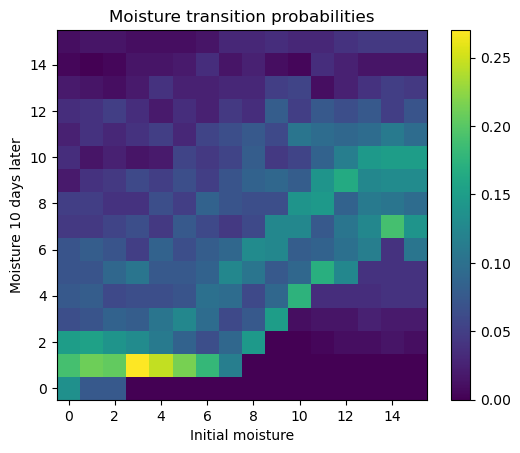

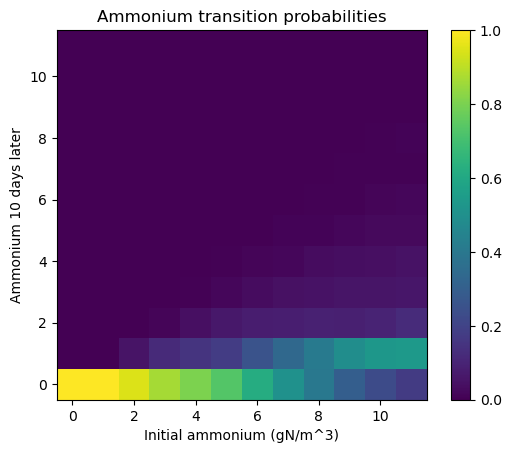

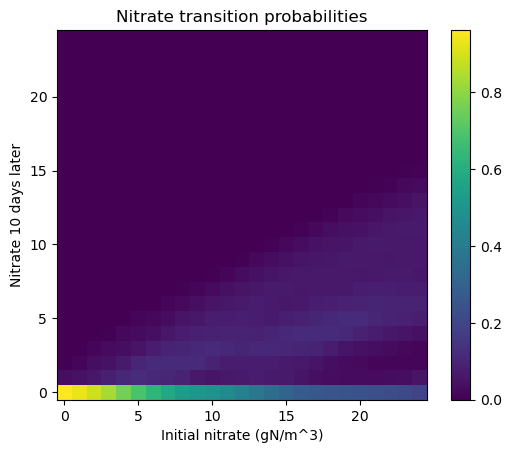

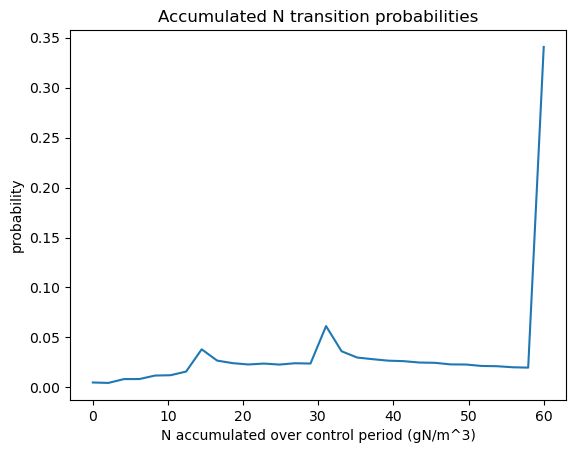

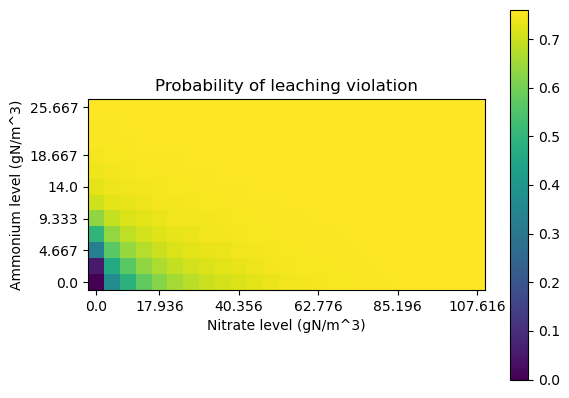

In [19]:
plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 3, 4, 5, 6, 8, 9), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * AMMONIUM_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Moisture transition probabilities")
plt.xlabel("Initial moisture")
plt.ylabel("Moisture " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 2, 4, 5, 6, 7, 9), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Ammonium transition probabilities")
plt.xlabel("Initial ammonium (gN/m^3)")
plt.ylabel("Ammonium " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 2, 3, 5, 6, 7, 8), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * AMMONIUM_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Nitrate transition probabilities")
plt.xlabel("Initial nitrate (gN/m^3)")
plt.ylabel("Nitrate " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.plot(np.linspace(0, MAX_SINGLE_STEP_ACCUMULATED_N, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS), np.sum(transition_counts, (0, 1, 2, 3, 4, 5, 7, 8, 9), np.float64) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * AMMONIUM_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS))
# plt.colorbar()
plt.title("Accumulated N transition probabilities")
plt.xlabel("N accumulated over control period (gN/m^3)")
plt.ylabel("probability")

display_moisture_slice(np.sum(transition_counts, (0, 1, 2, 6, 7, 8, 9), np.float64)[:, :, 1] / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * NUM_CONTROL_STEPS), "Probability of leaching violation")

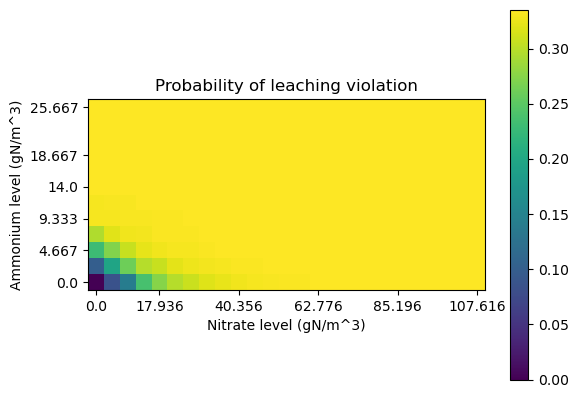

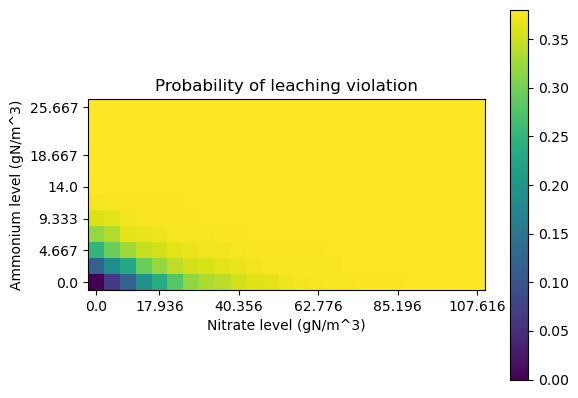

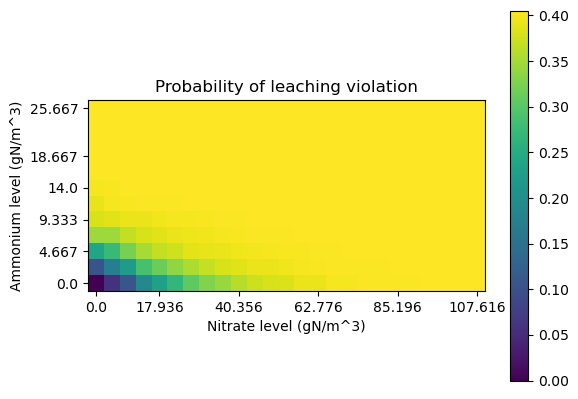

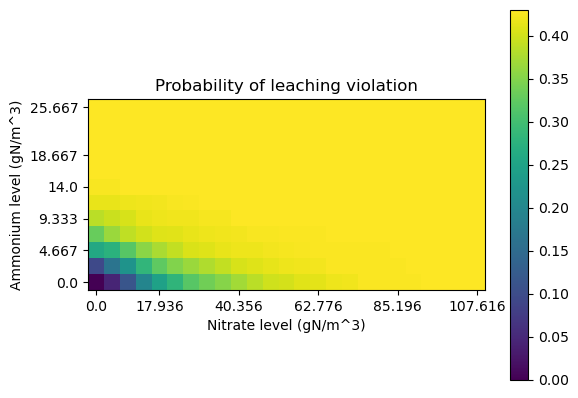

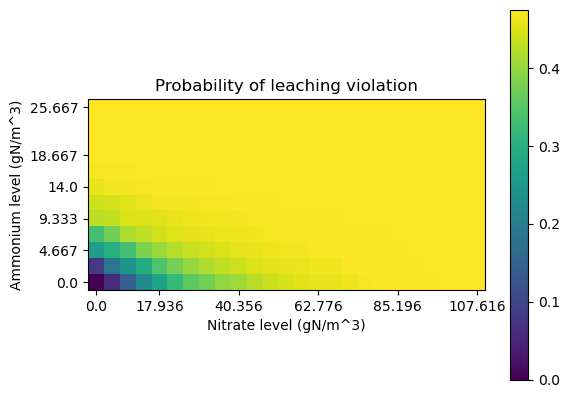

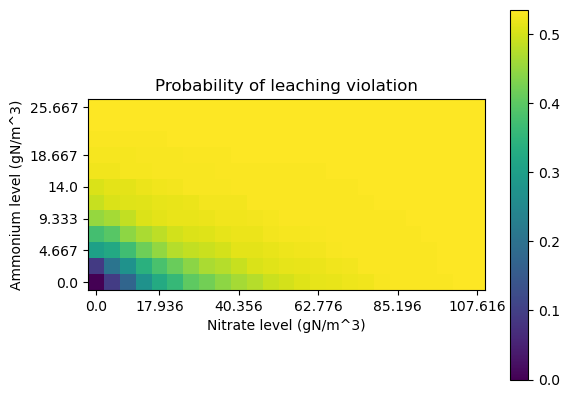

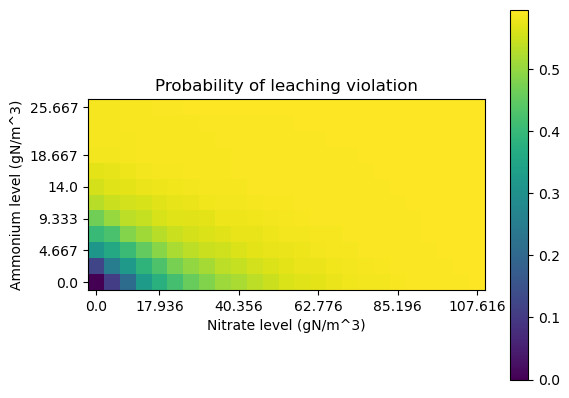

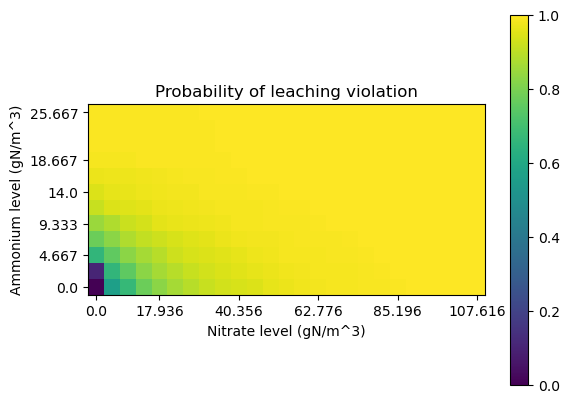

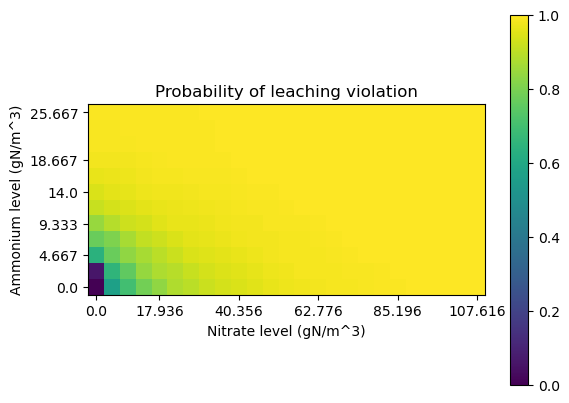

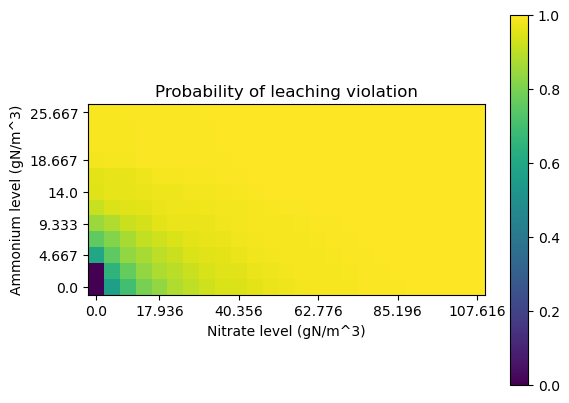

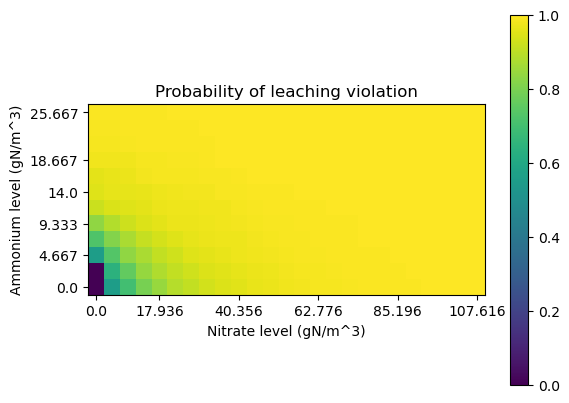

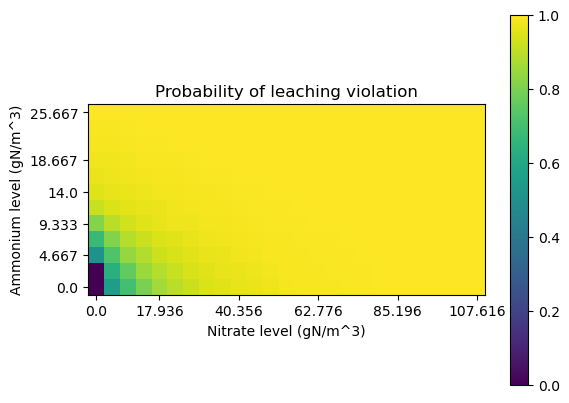

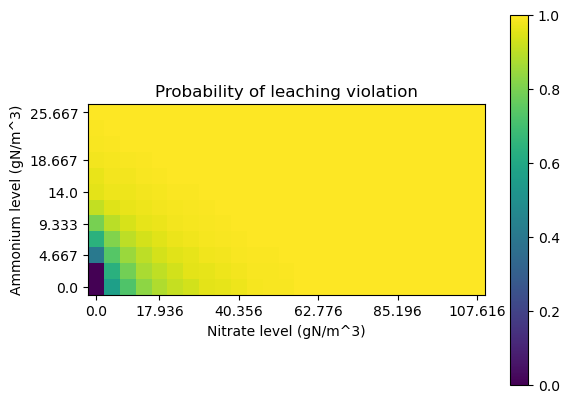

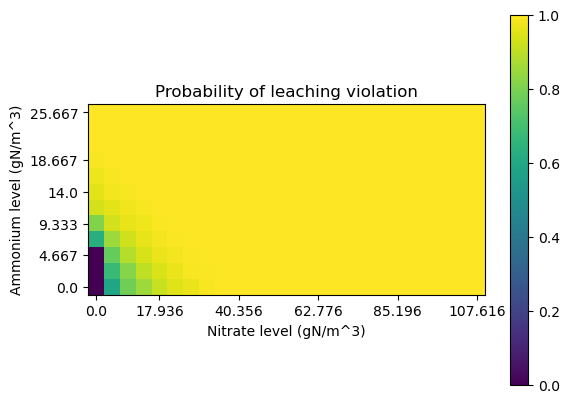

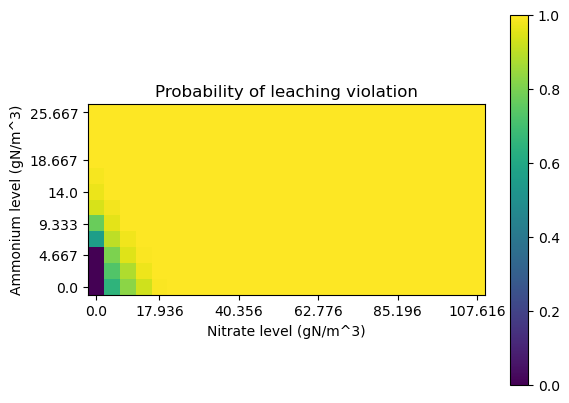

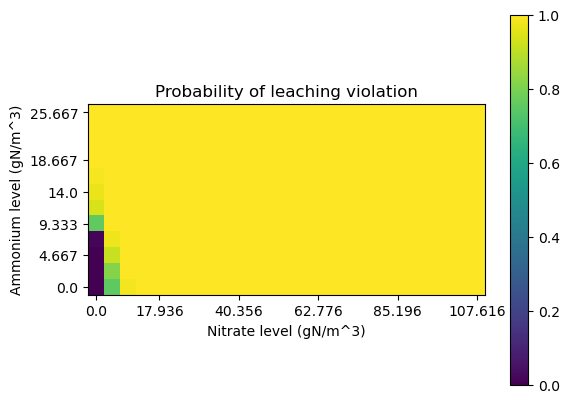

In [20]:
for i in range (MOISTURE_NUM_STEPS):
    display_moisture_slice(np.sum(transition_counts, (0, 1, 6, 7, 8, 9), np.float64)[i, :, :, 1] / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * NUM_CONTROL_STEPS), "Probability of leaching violation")

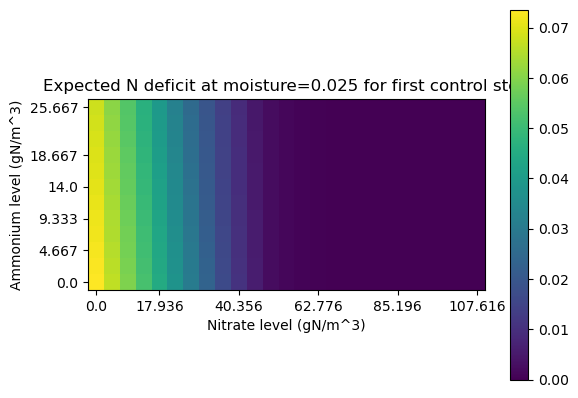

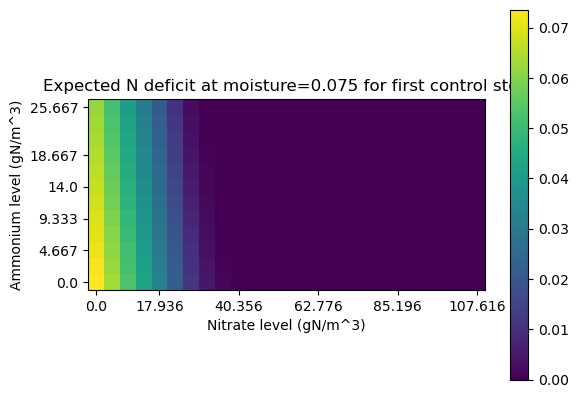

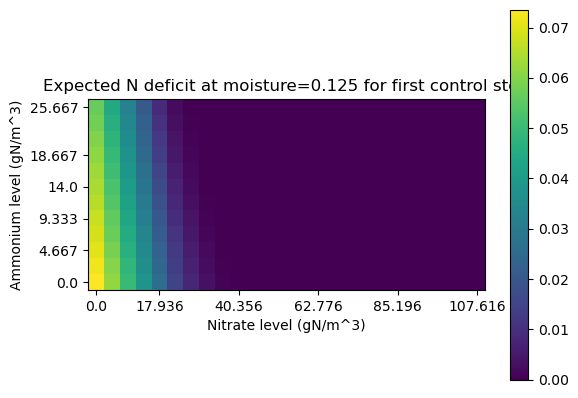

In [21]:
for i in range(3): # should be MOISTURE_NUM_STEPS but I'm tired of scrolling past a million plots
    display_moisture_slice(expected_plant_N_deficit_cost_USD[0, 0, 0, i], "Expected N deficit at moisture=" + moisture_idx_to_string(i) + " for first control step")
# plt.close()

In [22]:
#TODO irrigation?
def find_optimal_cost_and_input(cost_to_go_from_cell_without_fertilizer: npt.NDArray[np.float64], output_cost_to_go: npt.NDArray[np.float64], output_ammonium_add_cells: npt.NDArray[np.uint8], output_nitrate_add_cells: npt.NDArray[np.uint8]):
    for initial_accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
        for initial_forecast_index in range(2):
            for initial_moisture_index in range(MOISTURE_NUM_STEPS):
                for initial_ammonium_index in range(AMMONIUM_NUM_STEPS):
                    for initial_nitrate_index in range(NITRATE_NUM_STEPS):
                        optimal_cost = cost_to_go_from_cell_without_fertilizer[initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index]
                        optimal_ammonium_add = 0
                        optimal_nitrate_add = 0
                        _, _, pre_add_ammonium, pre_add_nitrate = indices_to_values(0, 0, initial_ammonium_index, initial_nitrate_index)
                        for post_add_ammonium_index in range(initial_ammonium_index, AMMONIUM_NUM_STEPS):
                            for post_add_nitrate_index in range(initial_nitrate_index, NITRATE_NUM_STEPS):
                                _, _, post_add_ammonium, post_add_nitrate = indices_to_values(0, 0, post_add_ammonium_index, post_add_nitrate_index)
                                added_n_cost_USD_per_m2 = N_PRICE_USD_PER_G * (SOIL_DEPTH_MM / 1000.) * (post_add_ammonium - pre_add_ammonium + post_add_nitrate - pre_add_nitrate)
                                total_cost = cost_to_go_from_cell_without_fertilizer[initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, post_add_ammonium_index, post_add_nitrate_index] + added_n_cost_USD_per_m2
                                if total_cost < optimal_cost:
                                    optimal_cost = total_cost
                                    optimal_ammonium_add = post_add_ammonium_index - initial_ammonium_index
                                    optimal_nitrate_add = post_add_nitrate_index - initial_nitrate_index
                        output_cost_to_go[initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index] = optimal_cost
                        output_ammonium_add_cells[initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index] = optimal_ammonium_add
                        output_nitrate_add_cells[initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index] = optimal_nitrate_add

## Base Case

In [23]:
# time, has leaching been violated, accumulated N, weather forecast, moisture, ammonium, nitrate
optimal_cost_to_go_USD_per_m2 = np.ndarray([NUM_CONTROL_STEPS, 2, ACCUMULATED_N_NUM_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
optimal_ammonium_add_in_cells = np.ndarray([NUM_CONTROL_STEPS, 2, ACCUMULATED_N_NUM_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint8)
optimal_nitrate_add_in_cells = np.ndarray([NUM_CONTROL_STEPS, 2, ACCUMULATED_N_NUM_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint8)

In [24]:
find_optimal_cost_and_input(expected_plant_N_deficit_cost_USD[-1], optimal_cost_to_go_USD_per_m2[-1, 1], optimal_ammonium_add_in_cells[-1, 1], optimal_nitrate_add_in_cells[-1, 1])
optimal_cost_to_go_USD_per_m2[-1, 1] += LEACHING_VIOLATION_PENALTY_USD_PER_M2 # penalize violation by adding the penalty at the end
# forecast, initial moisture, initial ammonium, initial nitrate
terminal_step_probability_of_violation = np.sum(transition_counts[NUM_CONTROL_STEPS - 1], (5, 6, 7, 8), np.float64)[:, :, :, :, 1] / NUM_TRIALS_PER_INITIAL_CONDITION
leaching_terminal_cost = LEACHING_VIOLATION_PENALTY_USD_PER_M2 * terminal_step_probability_of_violation
leaching_penalty_adjusted_terminal_deficit_cost_USD_per_m2 = expected_plant_N_deficit_cost_USD[-1].copy()
for i in range(ACCUMULATED_N_NUM_STEPS):
    leaching_penalty_adjusted_terminal_deficit_cost_USD_per_m2[i] += leaching_terminal_cost
find_optimal_cost_and_input(leaching_penalty_adjusted_terminal_deficit_cost_USD_per_m2, optimal_cost_to_go_USD_per_m2[-1, 0], optimal_ammonium_add_in_cells[-1, 0], optimal_nitrate_add_in_cells[-1, 0])

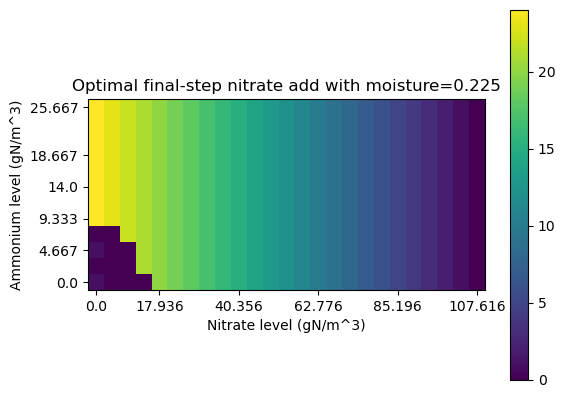

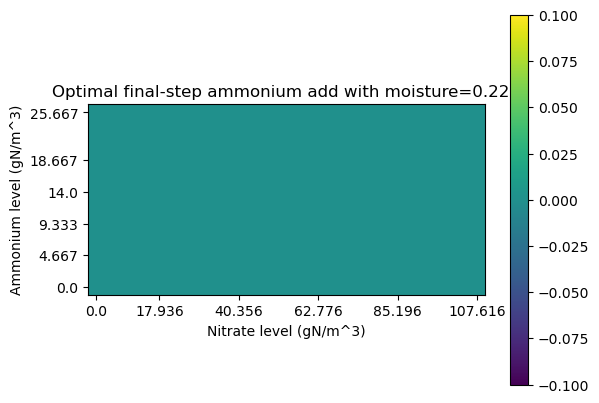

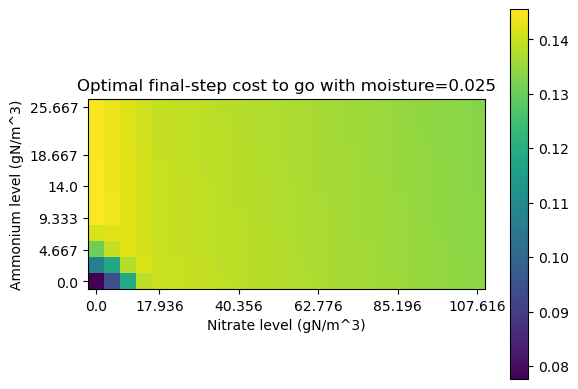

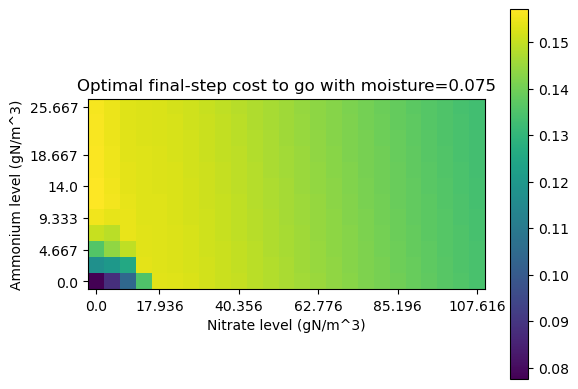

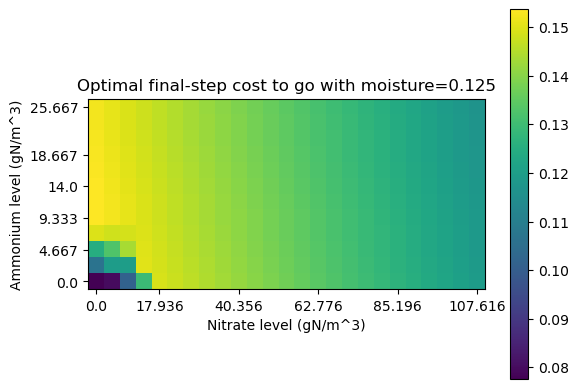

In [25]:
display_moisture_idx = 4
display_accumulated_N_idx = 0
display_moisture_slice(optimal_nitrate_add_in_cells[-1, 0, display_accumulated_N_idx, 0, display_moisture_idx], "Optimal final-step nitrate add with moisture=" + moisture_idx_to_string(display_moisture_idx))
display_moisture_slice(optimal_ammonium_add_in_cells[-1, 0, display_accumulated_N_idx, 0, display_moisture_idx], "Optimal final-step ammonium add with moisture=" + moisture_idx_to_string(display_moisture_idx))
for i in range(3): # should be MOISTURE_NUM_STEPS but i don't wanna scroll past that many plots
    display_moisture_slice(optimal_cost_to_go_USD_per_m2[-1, 0, display_accumulated_N_idx, 0, i], "Optimal final-step cost to go with moisture=" + moisture_idx_to_string(i))

## Recurse

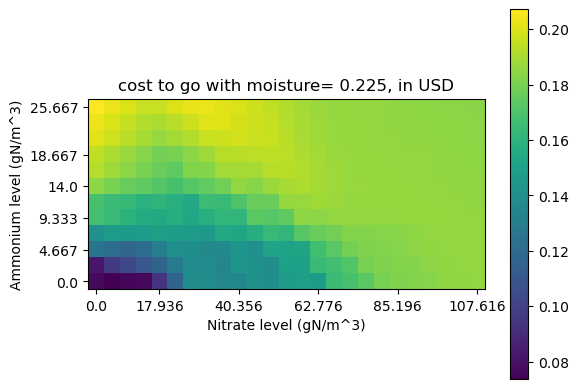

In [26]:
for i in reversed(range(NUM_CONTROL_STEPS - 1)):
    # leaching violated, accumulated N, forecast, starting moisture, starting ammonium, starting nitrate
    expected_cost_to_go_from_cell = np.ndarray([2, ACCUMULATED_N_NUM_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
    next_step_weather_averaged_optimal_cost_to_go_USD_per_m2 = optimal_cost_to_go_USD_per_m2[i + 1, :, :, 0] * PROBABILITY_OF_CLEAR_FORECAST + optimal_cost_to_go_USD_per_m2[i + 1, :, :, 1] * (1 - PROBABILITY_OF_CLEAR_FORECAST)
    for forecast_index in range(2):
        for moisture_index in range(MOISTURE_NUM_STEPS):
            for ammonium_index in range(AMMONIUM_NUM_STEPS):
                for nitrate_index in range(NITRATE_NUM_STEPS):
                    # this array is of outcome counts, dimensions are [change in accumulated N, moisture, ammonium, nitrate]
                    non_violating_transition_counts_from_zero_N = transition_counts[i, forecast_index, moisture_index, ammonium_index, nitrate_index, 0]
                    violating_transition_counts_from_zero_N = transition_counts[i, forecast_index, moisture_index, ammonium_index, nitrate_index, 1]

                    for accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
                        accumulated_N_window_end = accumulated_N_index + SINGLE_STEP_ACCUMULATED_N_NUM_STEPS
                        cost_for_invalid_transitions_without_penalty = 0
                        cost_for_invalid_transitions_with_penalty = 0

                        if accumulated_N_window_end > ACCUMULATED_N_NUM_STEPS:
                            # sum up the transition counts that would go "out of range" and find the cost using the top of the range
                            violating_invalid_transition_counts = violating_transition_counts_from_zero_N[-(accumulated_N_window_end - ACCUMULATED_N_NUM_STEPS):]
                            violating_valid_transition_counts = violating_transition_counts_from_zero_N[:-(accumulated_N_window_end - ACCUMULATED_N_NUM_STEPS)]
                            cost_for_first_violating_invalid_transitions = np.sum(np.sum(violating_invalid_transition_counts, axis=0) * (next_step_weather_averaged_optimal_cost_to_go_USD_per_m2[1, -1]))
                            non_violating_invalid_transition_counts = non_violating_transition_counts_from_zero_N[-(accumulated_N_window_end - ACCUMULATED_N_NUM_STEPS):]
                            non_violating_valid_transition_counts = non_violating_transition_counts_from_zero_N[:-(accumulated_N_window_end - ACCUMULATED_N_NUM_STEPS)]
                            cost_for_non_violating_invalid_transitions_from_unviolated = np.sum(np.sum(non_violating_invalid_transition_counts, axis=0) * (next_step_weather_averaged_optimal_cost_to_go_USD_per_m2[0, -1]))
                            cost_for_invalid_transitions_with_penalty = cost_for_first_violating_invalid_transitions + cost_for_non_violating_invalid_transitions_from_unviolated
                            cost_for_invalid_transitions_without_penalty = np.sum(np.sum(violating_invalid_transition_counts + non_violating_invalid_transition_counts, axis=0) * (next_step_weather_averaged_optimal_cost_to_go_USD_per_m2[1, -1]))
                            accumulated_N_window_end = ACCUMULATED_N_NUM_STEPS
                        else:
                            violating_valid_transition_counts = violating_transition_counts_from_zero_N
                            non_violating_valid_transition_counts = non_violating_transition_counts_from_zero_N
                        violated_cropped_optimal_cost_to_go = next_step_weather_averaged_optimal_cost_to_go_USD_per_m2[1, accumulated_N_index:accumulated_N_window_end]
                        unviolated_cropped_optimal_cost_to_go = next_step_weather_averaged_optimal_cost_to_go_USD_per_m2[0, accumulated_N_index:accumulated_N_window_end]
                        expected_cost_to_go_from_cell[0, accumulated_N_index, forecast_index, moisture_index, ammonium_index, nitrate_index] = (cost_for_invalid_transitions_with_penalty + np.sum(unviolated_cropped_optimal_cost_to_go * non_violating_valid_transition_counts) + np.sum((violated_cropped_optimal_cost_to_go) * violating_valid_transition_counts)) / NUM_TRIALS_PER_INITIAL_CONDITION
                        expected_cost_to_go_from_cell[1, accumulated_N_index, forecast_index, moisture_index, ammonium_index, nitrate_index] = (cost_for_invalid_transitions_without_penalty + np.sum(violated_cropped_optimal_cost_to_go * (non_violating_valid_transition_counts + violating_valid_transition_counts))) / NUM_TRIALS_PER_INITIAL_CONDITION
                        # expected_cost_to_go_from_cell[accumulated_N_index, moisture_index, ammonium_index, nitrate_index] = (np.sum(cropped_optimal_cost_to_go * valid_transition_counts) + cost_for_invalid_transitions) / NUM_TRIALS_PER_INITIAL_CONDITION
    if i == NUM_CONTROL_STEPS - 2:
        display_moisture_slice(expected_cost_to_go_from_cell[0, 0, 0, 4], "cost to go with moisture= " + moisture_idx_to_string(4) + ", in USD")
    expected_cost_to_go_from_cell[0] += expected_plant_N_deficit_cost_USD[i]
    expected_cost_to_go_from_cell[1] += expected_plant_N_deficit_cost_USD[i]
    # display_moisture_slice(expected_cost_to_go_from_cell[:, :, 1, 1], "Expected cost to go from cell at step " + str(i) + ", moisture=" + moisture_idx_to_string(1))
    find_optimal_cost_and_input(expected_cost_to_go_from_cell[0], optimal_cost_to_go_USD_per_m2[i, 0], optimal_ammonium_add_in_cells[i, 0], optimal_nitrate_add_in_cells[i, 0])
    find_optimal_cost_and_input(expected_cost_to_go_from_cell[1], optimal_cost_to_go_USD_per_m2[i, 1], optimal_ammonium_add_in_cells[i, 1], optimal_nitrate_add_in_cells[i, 1])

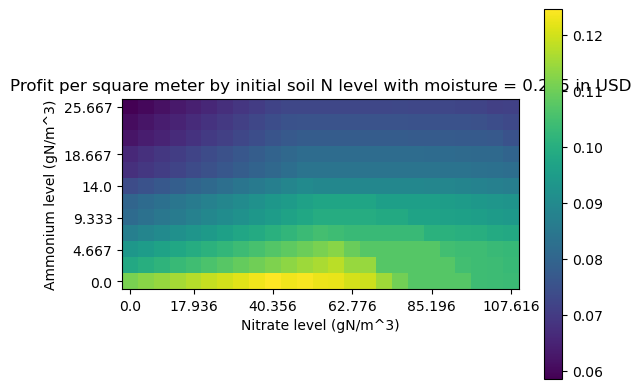

In [27]:
display_moisture_slice(N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - (optimal_cost_to_go_USD_per_m2[0, 0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST + optimal_cost_to_go_USD_per_m2[0, 0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)), "Profit per square meter by initial soil N level with moisture = " + moisture_idx_to_string(4) + " in USD")

In [28]:
probabilities_of_violation = np.ndarray([NUM_CONTROL_STEPS, ACCUMULATED_N_NUM_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
for initial_accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
    for initial_forecast_index in range(2):
        for initial_moisture_index in range(MOISTURE_NUM_STEPS):
            for initial_ammonium_index in range(AMMONIUM_NUM_STEPS):
                for initial_nitrate_index in range(NITRATE_NUM_STEPS):
                    post_add_ammonium = initial_ammonium_index + optimal_ammonium_add_in_cells[-1, 0, initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index]
                    post_add_nitrate = initial_nitrate_index + optimal_nitrate_add_in_cells[-1, 0, initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index]
                    probabilities_of_violation[-1, initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index] = terminal_step_probability_of_violation[initial_forecast_index, initial_moisture_index, post_add_ammonium, post_add_nitrate]

In [29]:
for i in reversed(range(NUM_CONTROL_STEPS - 1)):
    # forecast, moisture, ammonium, nitrate
    this_step_probability_of_violation = np.sum(transition_counts[i], (5, 6, 7, 8), np.float64)[:, :, :, :, 1] / NUM_TRIALS_PER_INITIAL_CONDITION
    next_step_weather_averaged_probability_of_violation = probabilities_of_violation[i + 1, :, 0] * PROBABILITY_OF_CLEAR_FORECAST + probabilities_of_violation[i + 1, :, 1] * (1 - PROBABILITY_OF_CLEAR_FORECAST)
    for initial_accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
        for initial_forecast_index in range(2):
            for initial_moisture_index in range(MOISTURE_NUM_STEPS):
                for initial_ammonium_index in range(AMMONIUM_NUM_STEPS):
                    for initial_nitrate_index in range(NITRATE_NUM_STEPS):
                        post_add_ammonium = initial_ammonium_index + optimal_ammonium_add_in_cells[i, 0, initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index]
                        post_add_nitrate = initial_nitrate_index + optimal_nitrate_add_in_cells[i, 0, initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index]
                        accumulated_N_window_end = initial_accumulated_N_index + SINGLE_STEP_ACCUMULATED_N_NUM_STEPS
                        if accumulated_N_window_end > ACCUMULATED_N_NUM_STEPS:
                            # We only want the non-violating counts, violating is accounted for elsewhere
                            windowed_transition_counts = transition_counts[i, initial_forecast_index, initial_moisture_index, post_add_ammonium, post_add_nitrate, 0, :(ACCUMULATED_N_NUM_STEPS - initial_accumulated_N_index)].copy() # accumulated N, moisture, ammonium, nitrate
                            windowed_transition_counts[-1] += np.sum(transition_counts[i, initial_forecast_index, initial_moisture_index, post_add_ammonium, post_add_nitrate, 0, (ACCUMULATED_N_NUM_STEPS - initial_accumulated_N_index):], axis=0)
                        else:
                            windowed_transition_counts = transition_counts[i, initial_forecast_index, initial_moisture_index, post_add_ammonium, post_add_nitrate, 0]
                        total_transition_counts = np.sum(windowed_transition_counts)
                        if total_transition_counts > 0:
                            probabilities_of_violation[i, initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index] = this_step_probability_of_violation[initial_forecast_index, initial_moisture_index, post_add_ammonium, post_add_nitrate] + np.sum(windowed_transition_counts * next_step_weather_averaged_probability_of_violation[initial_accumulated_N_index:min(accumulated_N_window_end, ACCUMULATED_N_NUM_STEPS)]) / total_transition_counts
                        else:
                            probabilities_of_violation[i, initial_accumulated_N_index, initial_forecast_index, initial_moisture_index, initial_ammonium_index, initial_nitrate_index] = this_step_probability_of_violation[initial_forecast_index, initial_moisture_index, post_add_ammonium, post_add_nitrate]

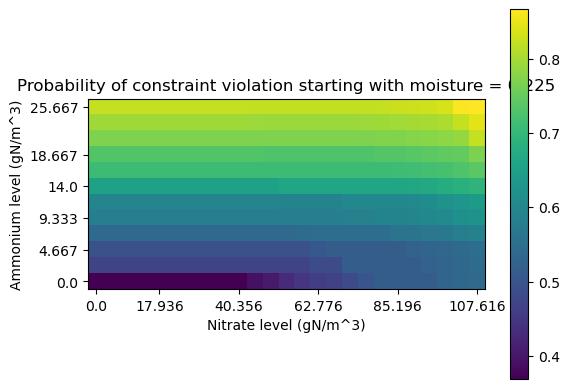

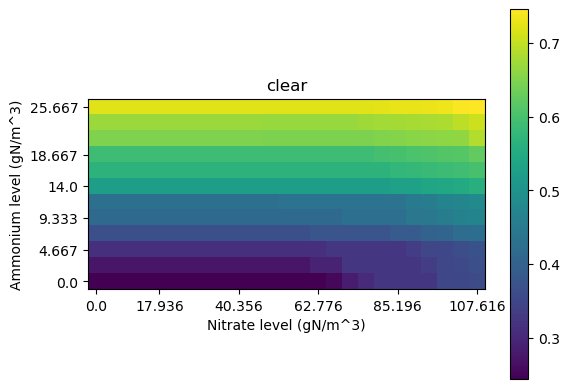

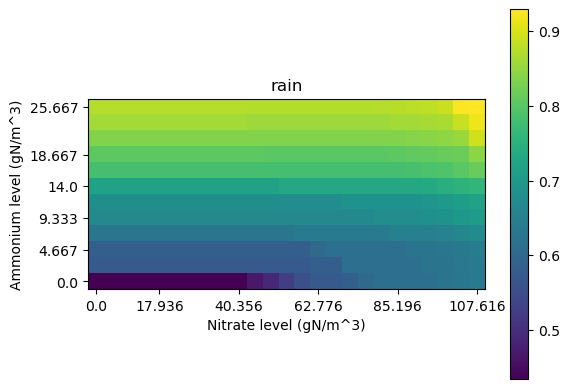

In [30]:
display_moisture_slice((probabilities_of_violation[0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST + probabilities_of_violation[0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)), "Probability of constraint violation starting with moisture = " + moisture_idx_to_string(4))
display_moisture_slice(probabilities_of_violation[0, 0, 0, 4], title="clear")
display_moisture_slice(probabilities_of_violation[0, 0, 1, 4], title="rain")

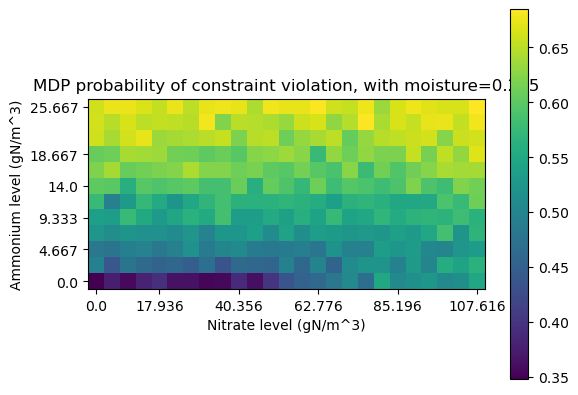

In [31]:
MDP_violation_probabilities = np.zeros([AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
num_MPD_trials = 1000
# forecast, moisture, post-add ammonium, post-add nitrate
violation_locations = np.zeros([2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint16)
for i in range(num_MPD_trials):
    for initial_ammonium_index in range(AMMONIUM_NUM_STEPS):
        for initial_nitrate_index in range(NITRATE_NUM_STEPS):
            accumulated_N_idx = 0
            current_moisture_idx = 4
            current_ammonium_idx = initial_ammonium_index
            current_nitrate_idx = initial_nitrate_index
            violated_constraint_yet = 0
            for control_step in range(NUM_CONTROL_STEPS):
                # Decide forecast
                forecast = 0 if rng.random() <= PROBABILITY_OF_CLEAR_FORECAST else 1

                # Fertilize according to controller
                ammonium_add = optimal_ammonium_add_in_cells[control_step, violated_constraint_yet, accumulated_N_idx, forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx]
                nitrate_add = optimal_nitrate_add_in_cells[control_step, violated_constraint_yet, accumulated_N_idx, forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx]
                current_ammonium_idx += ammonium_add
                current_nitrate_idx += nitrate_add

                # Sample transition from kernel
                relevant_kernel_region = transition_counts[control_step, forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx]
                possible_outcomes = []
                for nonzero_indicies in np.argwhere(relevant_kernel_region):
                    for num_counts in range(relevant_kernel_region[*nonzero_indicies]):
                        possible_outcomes.append(nonzero_indicies)
                transition_destination = rng.choice(possible_outcomes) # dimensions are: resulting leaching violation, resulting N accumulation, resulting moisture, resulting ammonium, resulting nitrate
                if initial_ammonium_index == 0 and initial_nitrate_index == 0 and violated_constraint_yet == 0 and transition_destination[0] == 1:
                    violation_locations[forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx] += 1
                violated_constraint_yet = min(1, violated_constraint_yet + transition_destination[0])
                accumulated_N_idx = min(ACCUMULATED_N_NUM_STEPS, accumulated_N_idx + transition_destination[1])
                current_moisture_idx = transition_destination[2]
                current_ammonium_idx = transition_destination[3]
                current_nitrate_idx = transition_destination[4]
            MDP_violation_probabilities[initial_ammonium_index, initial_nitrate_index] += violated_constraint_yet
MDP_violation_probabilities /= num_MPD_trials
display_moisture_slice(MDP_violation_probabilities, "MDP probability of constraint violation, with moisture=" + moisture_idx_to_string(4))

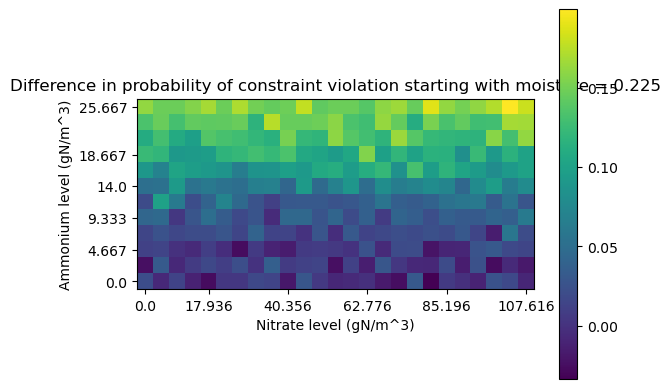

In [32]:
display_moisture_slice((probabilities_of_violation[0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST + probabilities_of_violation[0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)) - MDP_violation_probabilities, "Difference in probability of constraint violation starting with moisture = " + moisture_idx_to_string(4))

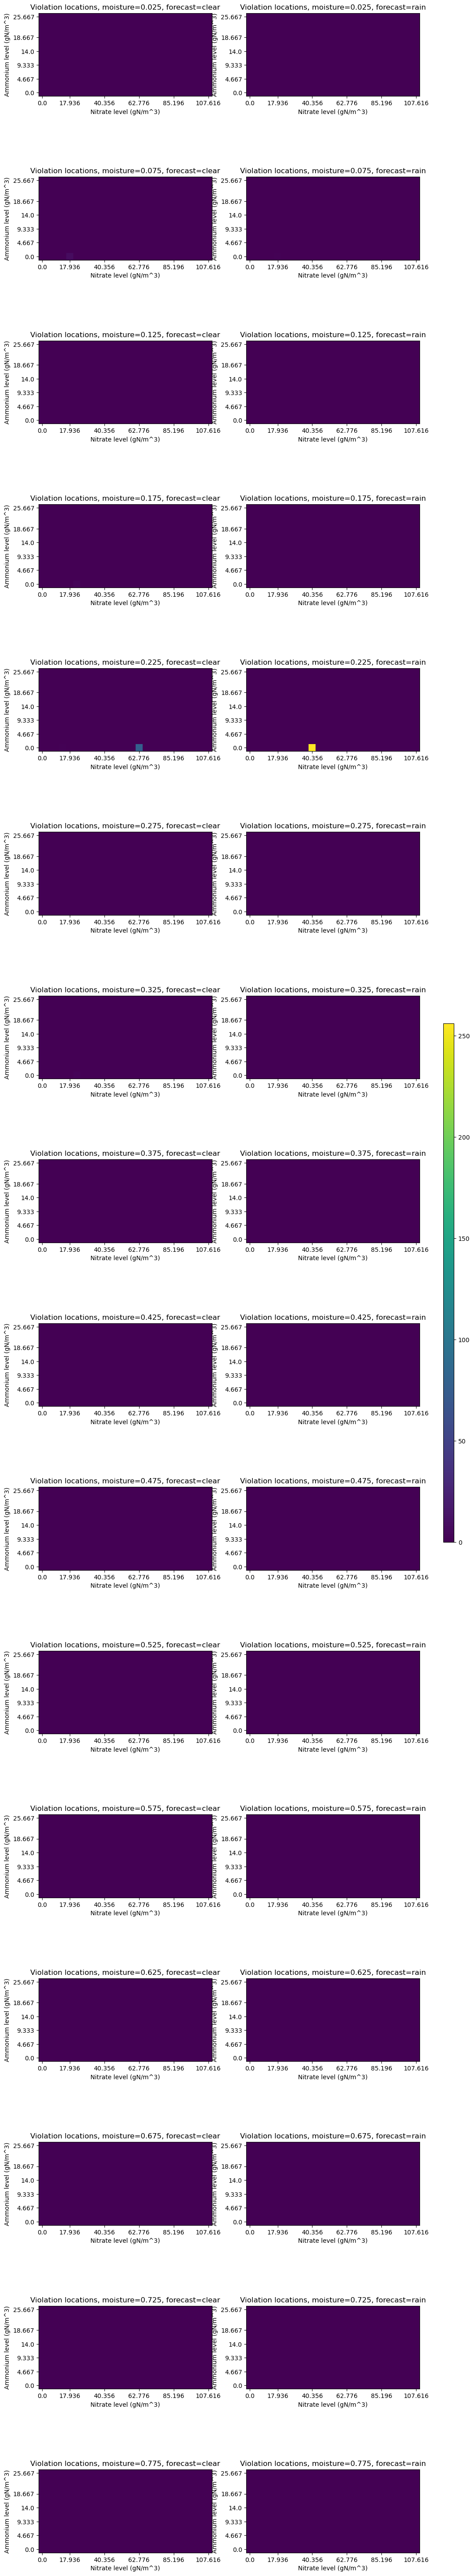

In [33]:
fig, axs = plt.subplots(MOISTURE_NUM_STEPS, 2, figsize=[7*2, 4.8 * MOISTURE_NUM_STEPS])
for moisture_index in range(MOISTURE_NUM_STEPS):
    for forecast in range(2):
        scalar_mappable = display_moisture_slice(violation_locations[forecast, moisture_index], "Violation locations, moisture="+moisture_idx_to_string(moisture_index)+ ", forecast=" + ("clear" if forecast == 0 else "rain"), fig=fig, ax=axs[moisture_index, forecast], colorbar=False, vmin=0, vmax=np.max(violation_locations))
fig.colorbar(scalar_mappable, ax=axs, aspect=50, shrink=0.2)

# Testing

In [34]:
import pickle

if False:
    with open('transition_counts.pickle', 'rb') as f:
        transition_counts = pickle.load(f)
    with open('expected_plant_N_deficit.pickle', 'rb') as f:
        expected_plant_N_deficit_cost_USD = pickle.load(f)

In [35]:
def run_controller(control_period_days: int, num_control_periods: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_litter_carbon_gC_per_m3: float = 1300.0, initial_litter_nitrogen_gN_per_m3: float = 38.2, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500, generate_figures: bool = True):
    rain_quantity_mm = generate_rain(control_period_days * num_control_periods)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(control_period_days * num_control_periods), np.zeros(control_period_days * num_control_periods))

    ammonium_gN_per_m3 = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3 = initial_nitrate_gN_per_m3
    accumulated_N_gN_per_m3 = 0
    ammonium_adds = np.ndarray(num_control_periods)
    nitrate_adds = np.ndarray(num_control_periods)
    forecasts = np.ndarray(num_control_periods)
    total_ammonium_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_ammonium_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_accumulated_N_gN_per_m3 = np.zeros(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrogen_deficit_cost = 0
    leaching_violated_yet = 0
    leaching_limit_violated_per_step = np.ndarray(num_control_periods, np.bool)

    for i in range(num_control_periods):
        start_day = i * control_period_days
        end_day = (i + 1) * control_period_days

        indices = values_to_indices(soil_moisture[i * control_period_days], ammonium_gN_per_m3, nitrate_gN_per_m3)
        accumulated_N_index = accumulated_N_value_to_index(accumulated_N_gN_per_m3)
        is_rain_forecast = int(any(rain_quantity_mm[start_day:start_day+FORECAST_LOOKAHEAD_DAYS] > 0))
        forecasts[i] = is_rain_forecast
        target_ammonium_index = optimal_ammonium_add_in_cells[i, leaching_violated_yet, accumulated_N_index, is_rain_forecast, *indices] + indices[1]
        target_nitrate_index = optimal_nitrate_add_in_cells[i, leaching_violated_yet, accumulated_N_index, is_rain_forecast, *indices] + indices[2]
        if target_ammonium_index == indices[1]:
            ammonium_adds[i] = 0
        else:
            ammonium_adds[i] = indices_to_values(0, 0, target_ammonium_index, 0)[2] - ammonium_gN_per_m3
        if target_nitrate_index == indices[2]:
            nitrate_adds[i] = 0
        else:
            nitrate_adds[i] = indices_to_values(0, 0, 0, target_nitrate_index)[3] - nitrate_gN_per_m3

        if generate_figures:
            fig, axs = plt.subplots(1, 4, figsize=[7*4, 4.8])

            display_moisture_slice(optimal_ammonium_add_in_cells[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]] * AMMONIUM_GRID_SIZE, "Optimal ammonium add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[0])
            display_moisture_slice(optimal_nitrate_add_in_cells[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]] * NITRATE_GRID_SIZE, "Optimal nitrate add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[1])
            display_moisture_slice(optimal_cost_to_go_USD_per_m2[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]], "Optimal cost to go for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[2])
            axs[3].set_title("N accumulation progress")
            x_series = np.arange(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS)) * INORGANIC_N_MODEL_DT_DAYS
            axs[3].plot(x_series[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], total_plant_accumulated_N_gN_per_m3[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], label="actual")
            axs[3].plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
            axs[3].set_ylabel("Total plant N accumulation (gN/m^3)")
            axs[3].set_xlabel("Day")
            axs[3].legend(loc="upper left")

        ammonium_gN_per_m3 = ammonium_gN_per_m3 + ammonium_adds[i]
        nitrate_gN_per_m3 = nitrate_gN_per_m3 + nitrate_adds[i]

        ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(ammonium_gN_per_m3, nitrate_gN_per_m3, float(i * control_period_days), leakage_rate_mm_per_day[start_day : end_day], transpiration_rate_mm_per_day[start_day : end_day], soil_moisture[start_day : end_day], net_flux_to_mineralized_nitrogen_g_per_m3_per_day[start_day : end_day], biomass_carbon_g_per_m3[start_day : end_day], output_dt_days=INORGANIC_N_MODEL_DT_DAYS)

        # total_nitrogen_deficit_cost += nitrogen_deficit_cost(plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS) + nitrogen_deficit_cost(plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS)
        total_ammonium_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_nitrogen_g_per_m3
        total_nitrate_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_nitrogen_g_per_m3
        total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_active_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_active_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_nitrate_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_leaching_gN_per_m3_per_day
        total_ammonium_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_leaching_gN_per_m3_per_day

        combined_N_uptake = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = np.cumsum(combined_N_uptake * INORGANIC_N_MODEL_DT_DAYS) + accumulated_N_gN_per_m3
        total_nitrogen_deficit_cost += nitrogen_deficit_cost(total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)], float(start_day), INORGANIC_N_MODEL_DT_DAYS)
        accumulated_N_gN_per_m3 = total_plant_accumulated_N_gN_per_m3[int(end_day / INORGANIC_N_MODEL_DT_DAYS) - 1]

        ammonium_gN_per_m3 = ammonium_nitrogen_g_per_m3[-1]
        nitrate_gN_per_m3 = nitrate_nitrogen_g_per_m3[-1]
        leaching_limit_violated_per_step[i] = leaching_limit_violated(leakage_rate_mm_per_day[start_day : end_day], ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, INORGANIC_N_MODEL_DT_DAYS)
        if leaching_violated_yet == 0:
            leaching_violated_yet = int(leaching_limit_violated_per_step[i])

    return total_nitrogen_deficit_cost, total_ammonium_nitrogen_g_per_m3, total_nitrate_nitrogen_g_per_m3, total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day, total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day, total_plant_active_uptake_of_ammonium_gN_per_m3_per_day, total_plant_active_uptake_of_nitrate_gN_per_m3_per_day, ammonium_adds, nitrate_adds, soil_moisture, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, total_ammonium_leaching_gN_per_m3_per_day, total_nitrate_leaching_gN_per_m3_per_day, total_plant_accumulated_N_gN_per_m3, leaching_violated_yet == 1 , leaching_limit_violated_per_step, forecasts

Lost yield due to N deficit: 0.00020881767749613567
Revenue: 0.2681473248408604
Expenditures: 0.03092758424343219
Profit: 0.2372197405974282
Leaching limit violated: True


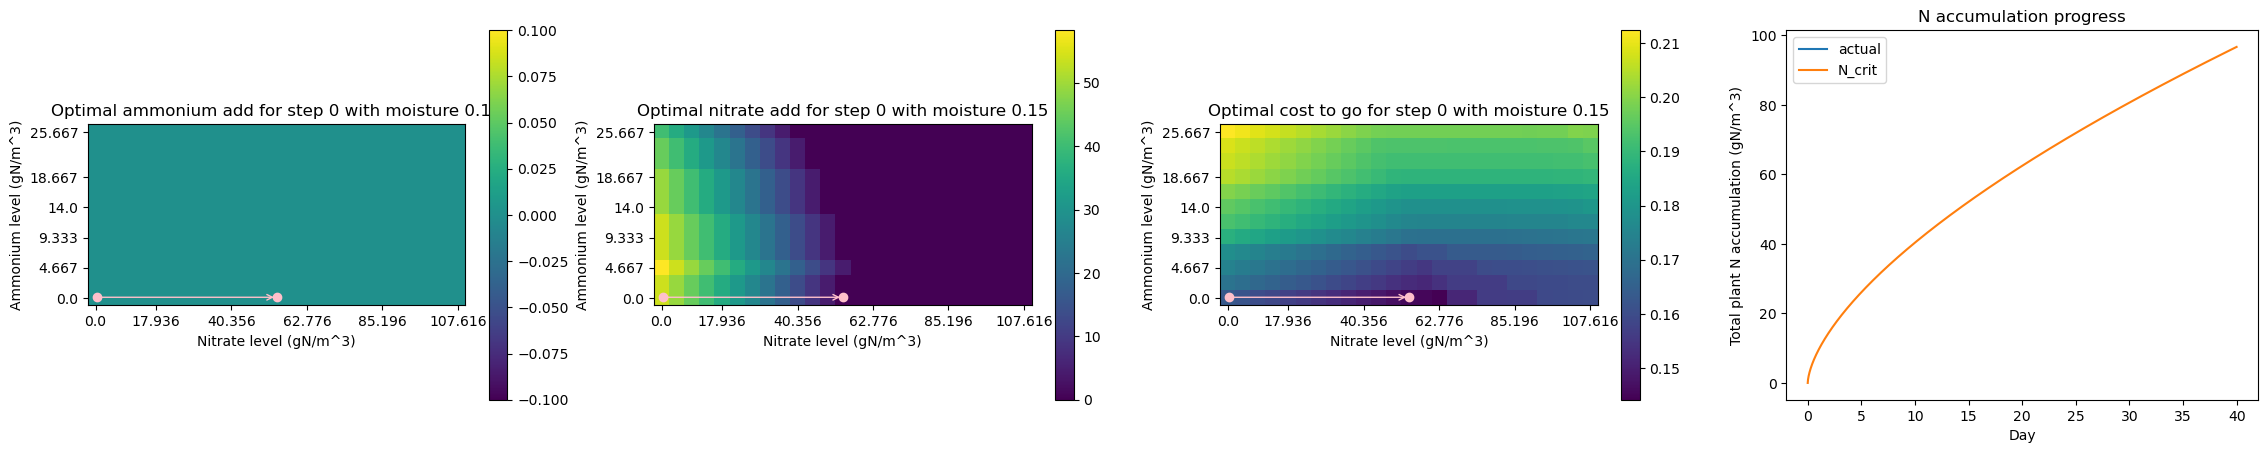

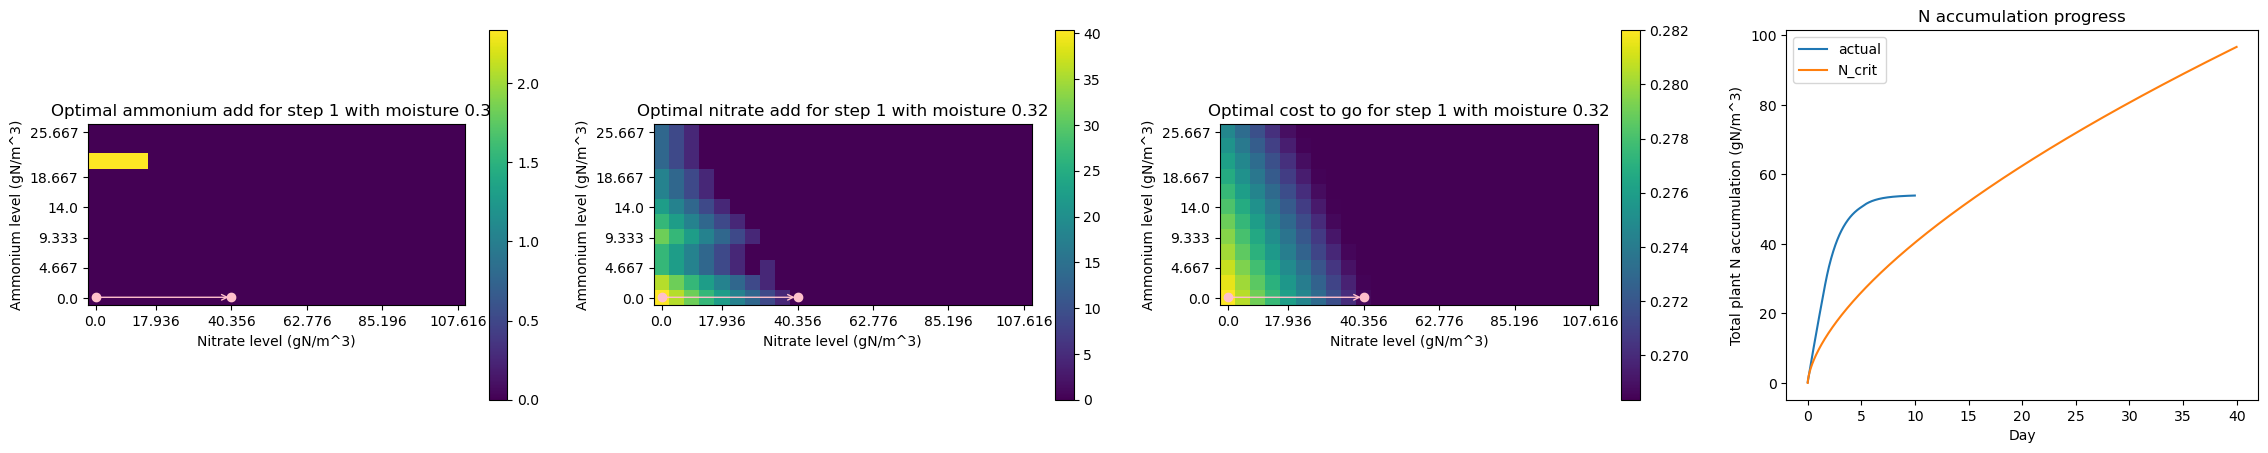

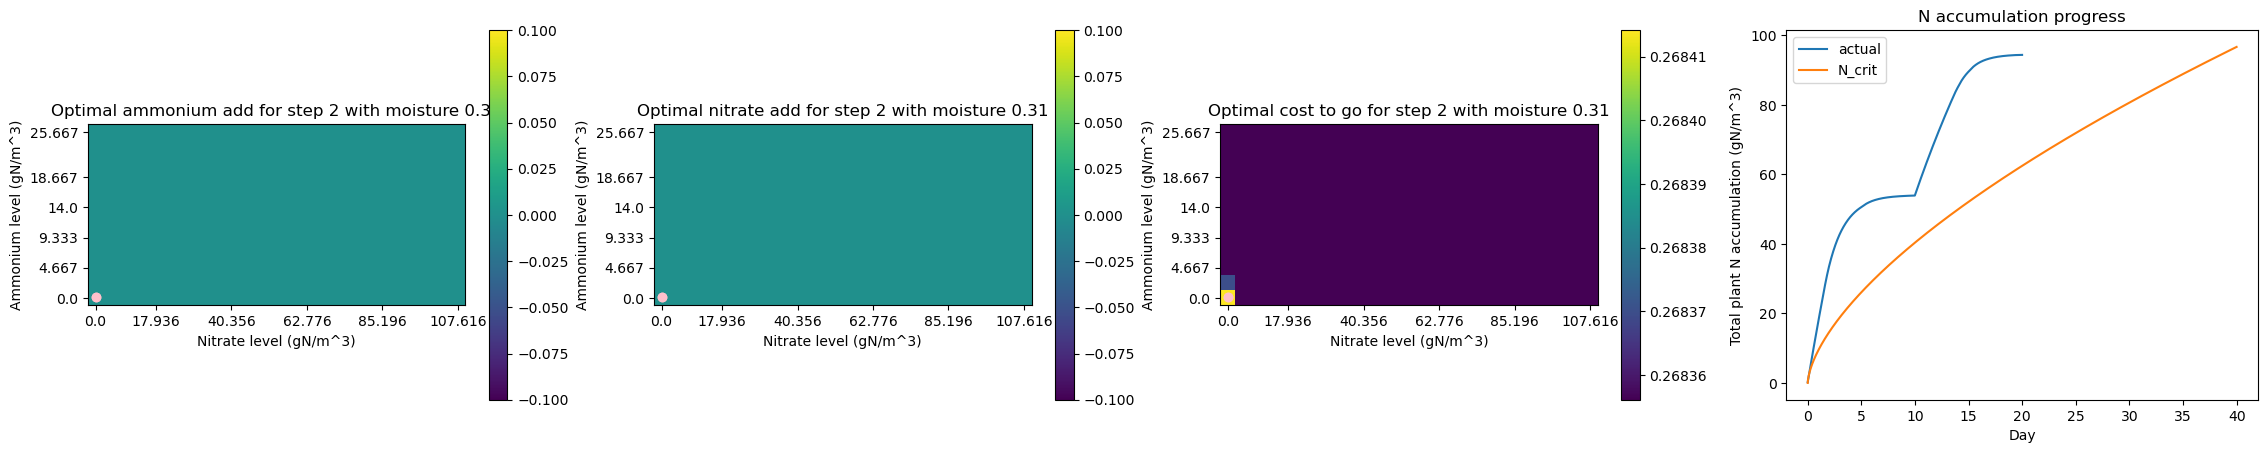

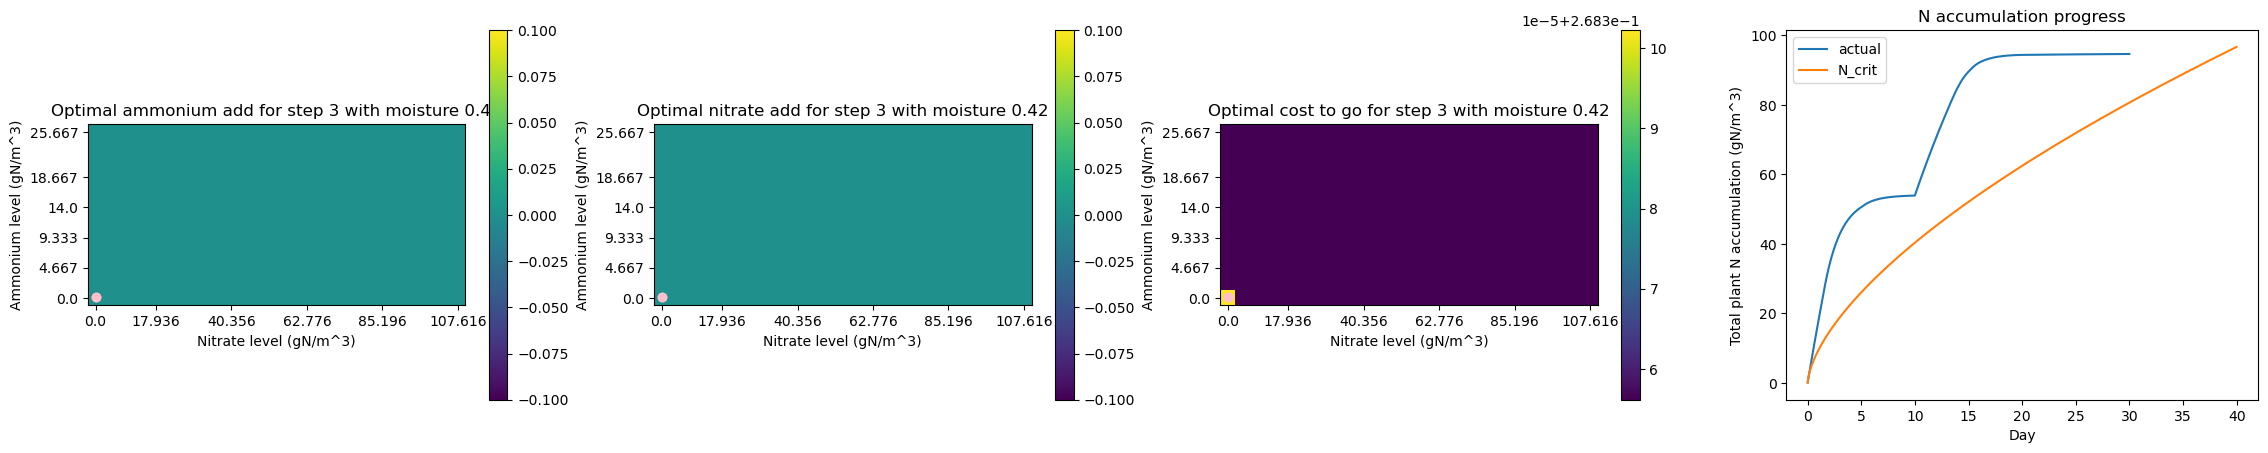

In [36]:
deficit_cost, ammonium, nitrate, ammonium_passive_uptake, nitrate_passive_uptake, ammonium_active_uptake, nitrate_active_uptake, added_ammonium, added_nitrate, experiment_soil_moisture, experiment_transpiration, experiment_leakage_mm_per_day, experiment_ammonium_leaching, experiment_nitrate_leaching, experiment_accumulated_N, experiment_leaching_limit_violated, experiment_per_step_leaching_limit_violated, experiment_forecasts = run_controller(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.15, 0.105, 0.3)
revenue = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - deficit_cost
expenditures = (np.sum(added_ammonium) + np.sum(added_nitrate)) * (SOIL_DEPTH_MM / 1000.) * N_PRICE_USD_PER_G
print("Lost yield due to N deficit: {}\nRevenue: {}\nExpenditures: {}\nProfit: {}".format(deficit_cost, revenue, expenditures, revenue - expenditures))
print("Leaching limit violated:", experiment_leaching_limit_violated)

[(0.0, 53.808), Text(0.5, 0, 'nitrate')]

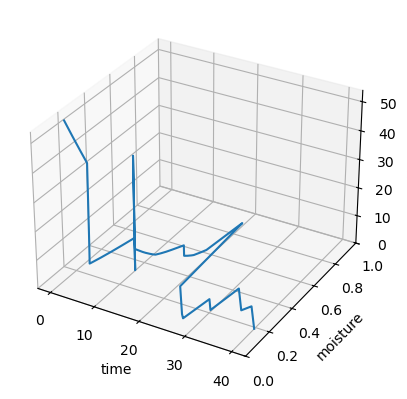

In [37]:
inorganic_n_times = np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS, len(ammonium))
upsampled_soil_moisture = np.interp(inorganic_n_times, np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS, len(experiment_soil_moisture)), experiment_soil_moisture)
maximum_n = max(np.max(ammonium), np.max(nitrate))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(inorganic_n_times, upsampled_soil_moisture, nitrate)
ax.set(xlabel="time")
ax.set(ylim3d=(0, 1), ylabel="moisture")
ax.set(zlim3d=(0, maximum_n), zlabel="nitrate")

In [38]:
added_ammonium

array([0., 0., 0., 0.])

In [39]:
added_nitrate

array([53.508     , 40.21195225,  0.        ,  0.        ])

In [40]:
minimum_nitrate_add = []
for i in range(NUM_CONTROL_STEPS):
    control_time_nitrate_idx = values_to_indices(0, 0.1, nitrate[i * int(CONTROL_TIMESTEP_DAYS / INORGANIC_N_MODEL_DT_DAYS)])[1]
    minimum_nitrate_add.append(indices_to_values(0, 0, 0, control_time_nitrate_idx + 1)[3] - indices_to_values(0, 0, 0, control_time_nitrate_idx)[3])
minimum_nitrate_add

[4.484, 4.484, 4.484, 4.484]

Text(0, 0.5, 'Nitrate concentration (gN/m^3)')

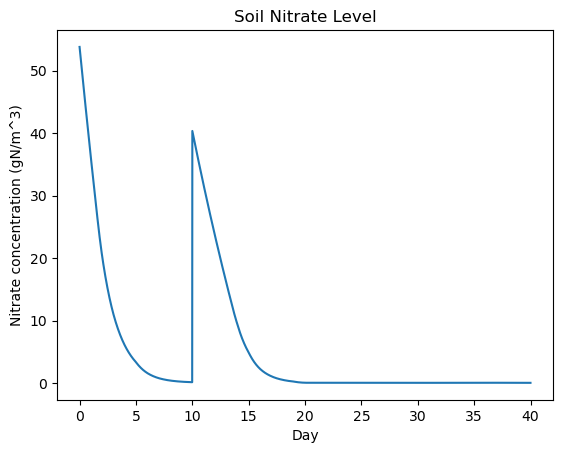

In [41]:
plt.plot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate)
plt.title("Soil Nitrate Level")
plt.xlabel("Day")
plt.ylabel("Nitrate concentration (gN/m^3)")

Text(0, 0.5, 'Ammonium concentration (gN/m^3)')

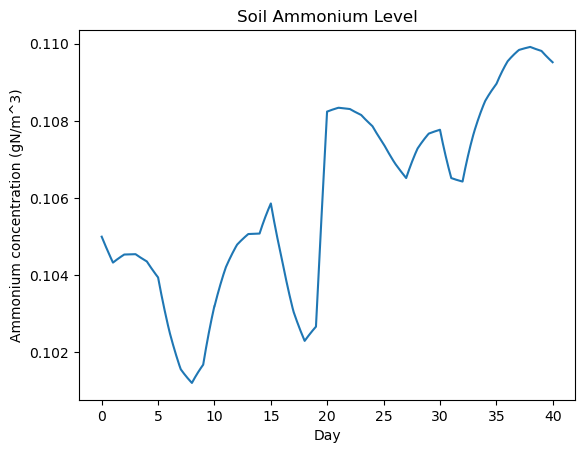

In [42]:
plt.plot(np.arange(len(ammonium)) * INORGANIC_N_MODEL_DT_DAYS, ammonium)
plt.title("Soil Ammonium Level")
plt.xlabel("Day")
plt.ylabel("Ammonium concentration (gN/m^3)")

Text(0.5, 0, 'Day')

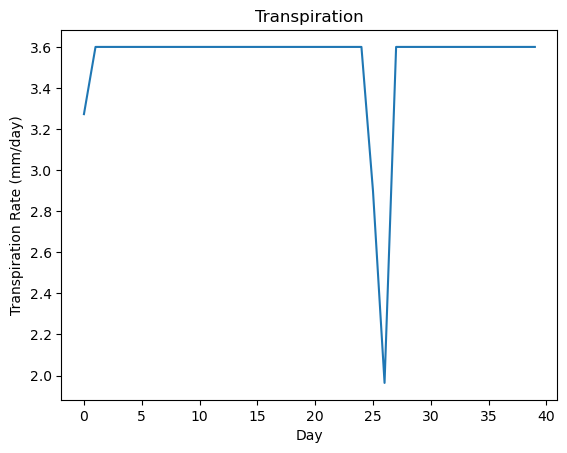

In [43]:
plt.plot(range(len(experiment_transpiration)), experiment_transpiration)
plt.title("Transpiration")
plt.ylabel("Transpiration Rate (mm/day)")
plt.xlabel("Day")

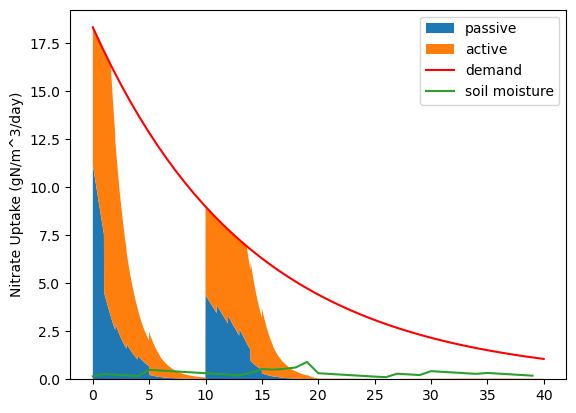

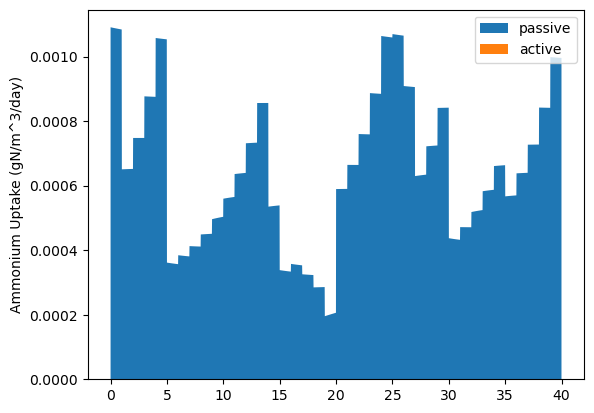

In [44]:
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate_passive_uptake, nitrate_active_uptake, labels=["passive", "active"])
plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)), color="red", label="demand")
plt.plot(range(len(experiment_soil_moisture)), experiment_soil_moisture, label="soil moisture") #TODO needs a different scale
plt.legend(loc="upper right")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(ammonium_active_uptake)) * INORGANIC_N_MODEL_DT_DAYS, ammonium_passive_uptake, ammonium_active_uptake, labels=["passive", "active"])
# plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)) / 2.0, color="red", label="demand")
plt.legend(loc="upper right")

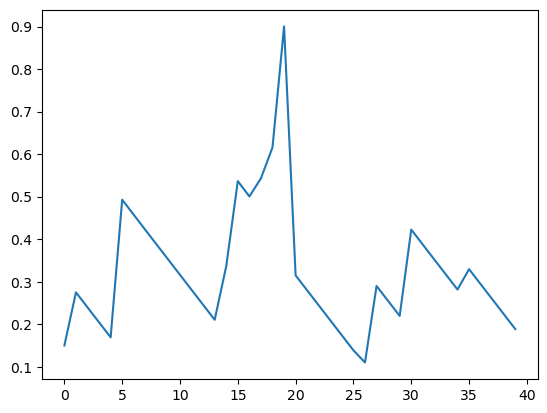

In [45]:
plt.plot(range(len(experiment_soil_moisture)), experiment_soil_moisture, label="soil moisture")

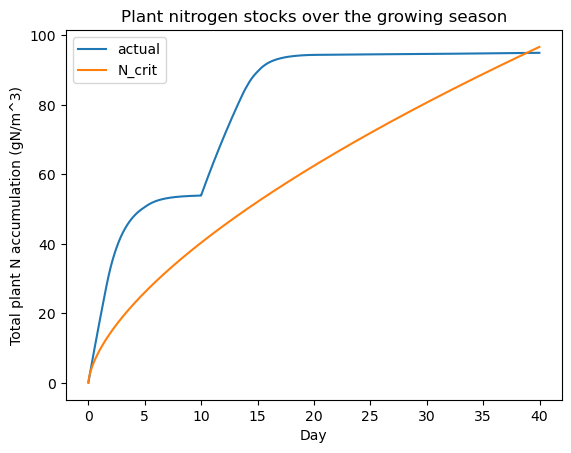

In [46]:
total_uptake = np.cumsum((ammonium_passive_uptake + nitrate_passive_uptake + ammonium_active_uptake + nitrate_active_uptake) * INORGANIC_N_MODEL_DT_DAYS)
plt.figure()
plt.title("Plant nitrogen stocks over the growing season")
x_series = np.arange(len(total_uptake)) * INORGANIC_N_MODEL_DT_DAYS
plt.plot(x_series, total_uptake, label="actual")
plt.ylabel("Total plant N accumulation (gN/m^3)")
plt.xlabel("Day")
plt.plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
plt.legend(loc="upper left")

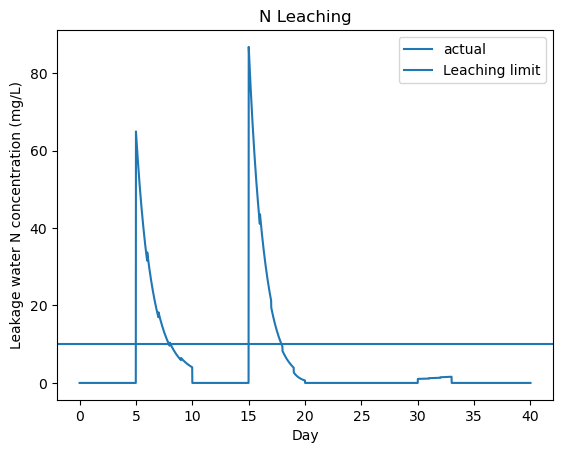

In [47]:
leaching_time_series = np.linspace(0, NUM_DAYS_TOTAL, len(experiment_nitrate_leaching))
leaching_concentration_gN_per_L = np.zeros(experiment_nitrate_leaching.shape)
for large_array_idx in range(len(leaching_time_series) - 1):
    small_array_idx = int(leaching_time_series[large_array_idx])
    if experiment_leakage_mm_per_day[small_array_idx] > 0:
        leaching_concentration_gN_per_L[large_array_idx] = (experiment_nitrate_leaching[large_array_idx] + experiment_ammonium_leaching[large_array_idx]) / experiment_leakage_mm_per_day[small_array_idx]
plt.figure()
plt.title("N Leaching")
plt.plot(leaching_time_series, leaching_concentration_gN_per_L * 1000, label="actual")
plt.axhline(y=LEACHING_CONCENTRATION_LIMIT_MG_PER_LITER, label="Leaching limit")
plt.xlabel("Day")
plt.ylabel("Leakage water N concentration (mg/L)")
plt.legend(loc="upper right")
# plt.plot(range(40), experiment_leakage_mm_per_day)

In [48]:
average_profit = 0
probability_of_violation = 0
n_trials = 100
continuous_trials_violation_locations = np.zeros([2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint16)
for i in range(n_trials):
    deficit_cost, ammonium, nitrate, ammonium_passive_uptake, nitrate_passive_uptake, ammonium_active_uptake, nitrate_active_uptake, added_ammonium, added_nitrate, experiment_soil_moisture, experiment_transpiration, experiment_leakage_mm_per_day, experiment_ammonium_leaching, experiment_nitrate_leaching, experiment_accumulated_N, experiment_leaching_limit_violated, experiment_per_step_leaching_limit_violated, experiment_forecasts = run_controller(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.225, 0.0, 0.0, generate_figures=False)
    revenue = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - deficit_cost
    expenditures = (np.sum(added_ammonium) + np.sum(added_nitrate)) * (SOIL_DEPTH_MM / 1000.) * N_PRICE_USD_PER_G
    profit = revenue - expenditures
    if experiment_leaching_limit_violated:
        profit -= LEACHING_VIOLATION_PENALTY_USD_PER_M2
        probability_of_violation += 1
        violating_step = np.where(experiment_per_step_leaching_limit_violated == 1)[0][0]
        continuous_trials_violation_locations[int(experiment_forecasts[violating_step]), *values_to_indices(experiment_soil_moisture[violating_step * CONTROL_TIMESTEP_DAYS], ammonium[int(violating_step * CONTROL_TIMESTEP_DAYS / INORGANIC_N_MODEL_DT_DAYS)], nitrate[int(violating_step * CONTROL_TIMESTEP_DAYS / INORGANIC_N_MODEL_DT_DAYS)])] += 1
    average_profit += profit
average_profit /= n_trials
probability_of_violation = float(probability_of_violation) / n_trials
print("Probability of violation: {}\nAverage profit: {}".format(probability_of_violation, average_profit))

Probability of violation: 0.36
Average profit: 0.11226328178751074


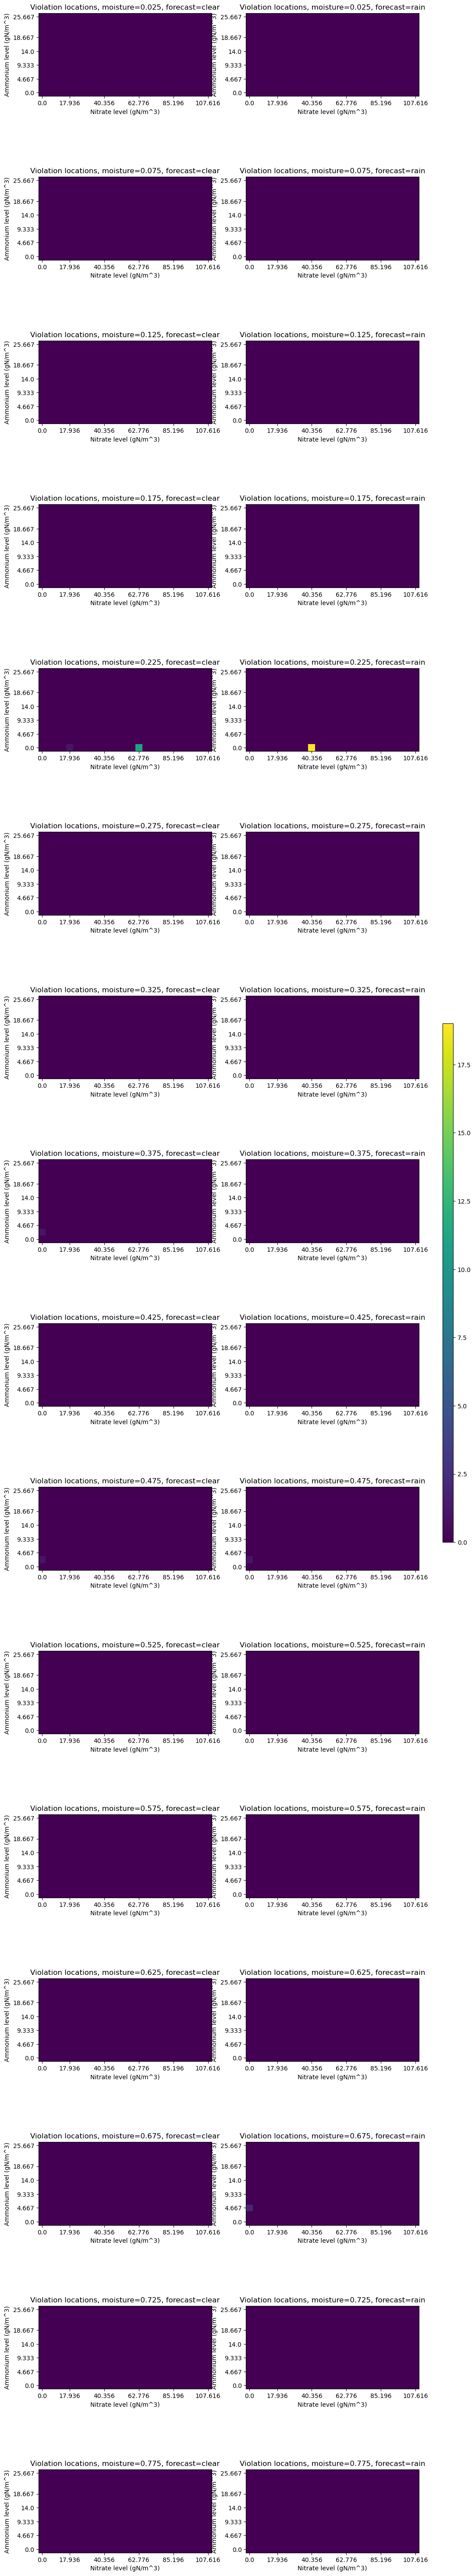

In [49]:
fig, axs = plt.subplots(MOISTURE_NUM_STEPS, 2, figsize=[7*2, 4.8 * MOISTURE_NUM_STEPS])
for moisture_index in range(MOISTURE_NUM_STEPS):
    for forecast in range(2):
        scalar_mappable = display_moisture_slice(continuous_trials_violation_locations[forecast, moisture_index], "Violation locations, moisture="+moisture_idx_to_string(moisture_index)+ ", forecast=" + ("clear" if forecast == 0 else "rain"), fig=fig, ax=axs[moisture_index, forecast], colorbar=False, vmin=0, vmax=np.max(continuous_trials_violation_locations))
fig.colorbar(scalar_mappable, ax=axs, aspect=50, shrink=0.2)

In [50]:
def run_simulation_open_loop(control_period_days: int, num_control_periods: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, nitrate_adds: List[float], ammonium_adds: List[float], initial_litter_carbon_gC_per_m3: float = 1300.0, initial_litter_nitrogen_gN_per_m3: float = 38.2, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500):
    rain_quantity_mm = generate_rain(control_period_days * num_control_periods)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(control_period_days * num_control_periods), np.zeros(control_period_days * num_control_periods))

    ammonium_gN_per_m3 = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3 = initial_nitrate_gN_per_m3
    accumulated_N_gN_per_m3 = 0
    total_ammonium_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_ammonium_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_accumulated_N_gN_per_m3 = np.zeros(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrogen_deficit_cost = 0

    for i in range(num_control_periods):
        start_day = i * control_period_days
        end_day = (i + 1) * control_period_days

        indices = values_to_indices(soil_moisture[i * control_period_days], ammonium_gN_per_m3, nitrate_gN_per_m3)
        accumulated_N_index = accumulated_N_value_to_index(accumulated_N_gN_per_m3)

        fig, axs = plt.subplots(1, 4, figsize=[6.4*4, 4.8])

        display_moisture_slice(optimal_ammonium_add_in_cells[i, accumulated_N_index, indices[0]] * AMMONIUM_GRID_SIZE, "Optimal ammonium add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[0])
        display_moisture_slice(optimal_nitrate_add_in_cells[i, accumulated_N_index, indices[0]] * NITRATE_GRID_SIZE, "Optimal nitrate add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[1])
        display_moisture_slice(optimal_cost_to_go_USD_per_m2[i, accumulated_N_index, indices[0]], "Optimal cost to go for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[2])
        axs[3].set_title("N accumulation progress")
        x_series = np.arange(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS)) * INORGANIC_N_MODEL_DT_DAYS
        axs[3].plot(x_series[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], total_plant_accumulated_N_gN_per_m3[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], label="actual")
        axs[3].plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
        axs[3].set_ylabel("Total plant N accumulation (gN/m^3)")
        axs[3].set_xlabel("Day")
        axs[3].legend(loc="upper left")

        ammonium_gN_per_m3 = ammonium_gN_per_m3 + ammonium_adds[i]
        nitrate_gN_per_m3 = nitrate_gN_per_m3 + nitrate_adds[i]

        ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(ammonium_gN_per_m3, nitrate_gN_per_m3, float(i * control_period_days), leakage_rate_mm_per_day[start_day : end_day], transpiration_rate_mm_per_day[start_day : end_day], soil_moisture[start_day : end_day], net_flux_to_mineralized_nitrogen_g_per_m3_per_day[start_day : end_day], biomass_carbon_g_per_m3[start_day : end_day], output_dt_days=INORGANIC_N_MODEL_DT_DAYS)

        # total_nitrogen_deficit_cost += nitrogen_deficit_cost(plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS) + nitrogen_deficit_cost(plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS)
        total_ammonium_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_nitrogen_g_per_m3
        total_nitrate_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_nitrogen_g_per_m3
        total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_active_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_active_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_nitrate_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_leaching_gN_per_m3_per_day
        total_ammonium_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_leaching_gN_per_m3_per_day

        combined_N_uptake = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = np.cumsum(combined_N_uptake * INORGANIC_N_MODEL_DT_DAYS) + accumulated_N_gN_per_m3
        total_nitrogen_deficit_cost += nitrogen_deficit_cost(total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)], float(start_day), INORGANIC_N_MODEL_DT_DAYS)
        accumulated_N_gN_per_m3 = total_plant_accumulated_N_gN_per_m3[int(end_day / INORGANIC_N_MODEL_DT_DAYS) - 1]

        ammonium_gN_per_m3 = ammonium_nitrogen_g_per_m3[-1]
        nitrate_gN_per_m3 = nitrate_nitrogen_g_per_m3[-1]

    return total_nitrogen_deficit_cost, total_ammonium_nitrogen_g_per_m3, total_nitrate_nitrogen_g_per_m3, total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day, total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day, total_plant_active_uptake_of_ammonium_gN_per_m3_per_day, total_plant_active_uptake_of_nitrate_gN_per_m3_per_day, ammonium_adds, nitrate_adds, soil_moisture, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, total_ammonium_leaching_gN_per_m3_per_day, total_nitrate_leaching_gN_per_m3_per_day, total_plant_accumulated_N_gN_per_m3

TypeError: Invalid shape (2, 16, 12, 25) for image data

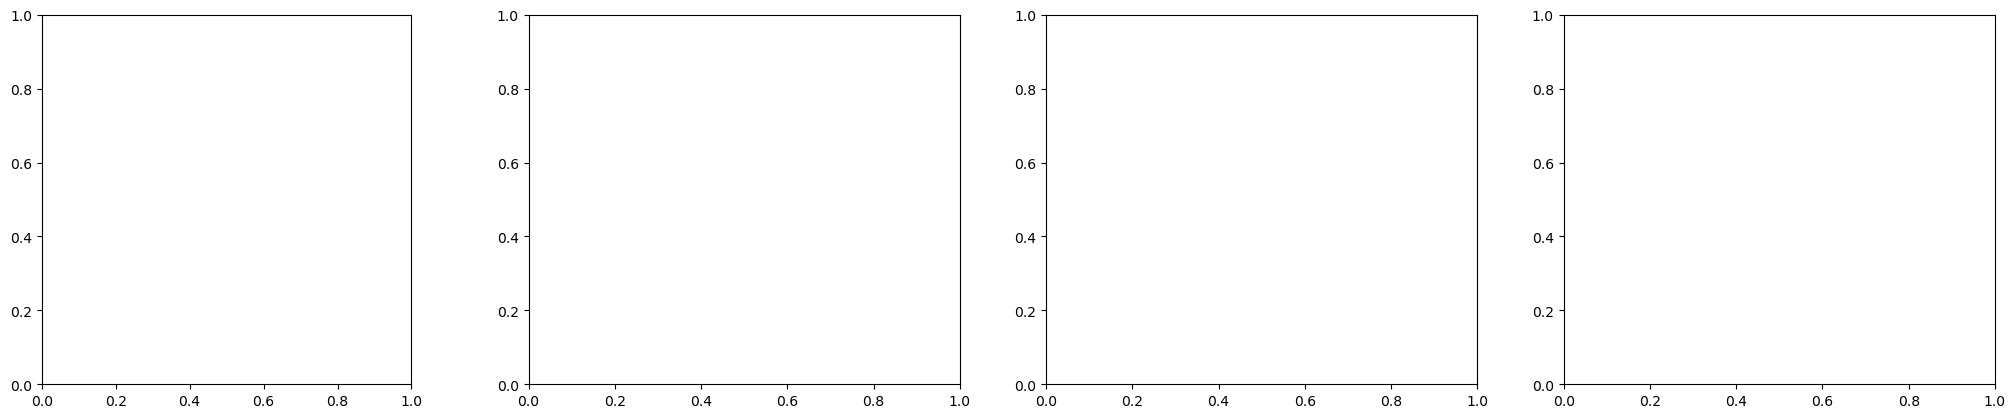

In [51]:
deficit_cost, ammonium, nitrate, ammonium_passive_uptake, nitrate_passive_uptake, ammonium_active_uptake, nitrate_active_uptake, added_ammonium, added_nitrate, experiment_soil_moisture, experiment_transpiration, experiment_leakage_mm_per_day, experiment_ammonium_leaching, experiment_nitrate_leaching, experiment_accumulated_N = run_simulation_open_loop(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.15, 0.105, 0.3, [5 / (SOIL_DEPTH_MM / 1000), 0, 0, 0], [25 / (SOIL_DEPTH_MM / 1000), 0, 0, 0])
revenue = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - deficit_cost
expenditures = (np.sum(added_ammonium) + np.sum(added_nitrate)) * (SOIL_DEPTH_MM / 1000.) * N_PRICE_USD_PER_G
print("Revenue: {}\nExpenditures: {}\nProfit: {}".format(revenue, expenditures, revenue - expenditures))

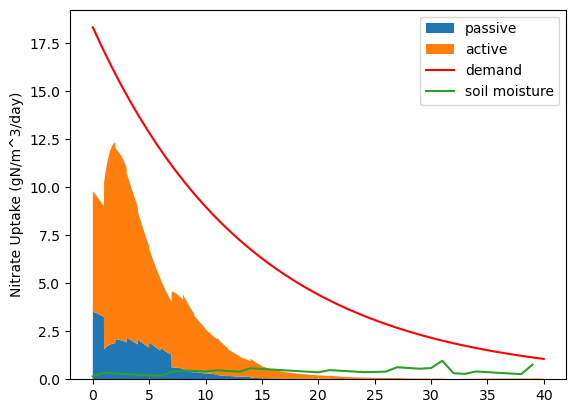

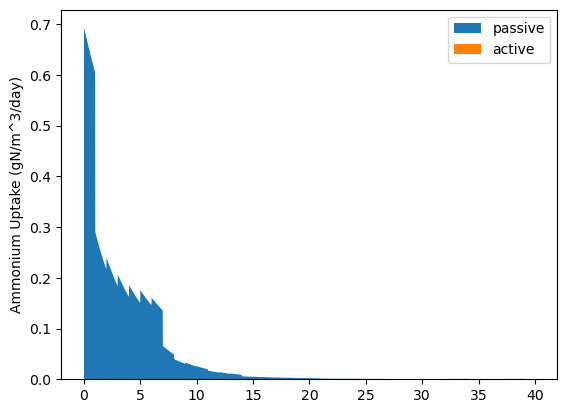

In [145]:
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate_passive_uptake, nitrate_active_uptake, labels=["passive", "active"])
plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)), color="red", label="demand")
plt.plot(range(len(experiment_soil_moisture)), experiment_soil_moisture, label="soil moisture")
plt.legend(loc="upper right")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(ammonium_active_uptake)) * INORGANIC_N_MODEL_DT_DAYS, ammonium_passive_uptake, ammonium_active_uptake, labels=["passive", "active"])
# plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)) / 2.0, color="red", label="demand")
plt.legend(loc="upper right")

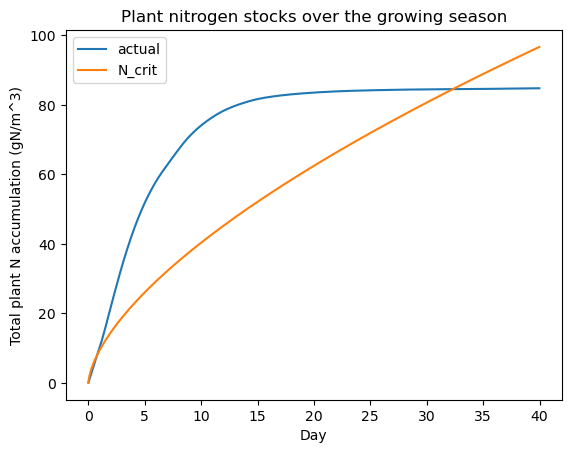

In [146]:
total_uptake = np.cumsum((ammonium_passive_uptake + nitrate_passive_uptake + ammonium_active_uptake + nitrate_active_uptake) * INORGANIC_N_MODEL_DT_DAYS)
plt.figure()
plt.title("Plant nitrogen stocks over the growing season")
x_series = np.arange(len(total_uptake)) * INORGANIC_N_MODEL_DT_DAYS
plt.plot(x_series, total_uptake, label="actual")
plt.ylabel("Total plant N accumulation (gN/m^3)")
plt.xlabel("Day")
plt.plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
plt.legend(loc="upper left")

Text(0, 0.5, 'Nitrate concentration (gN/m^3)')

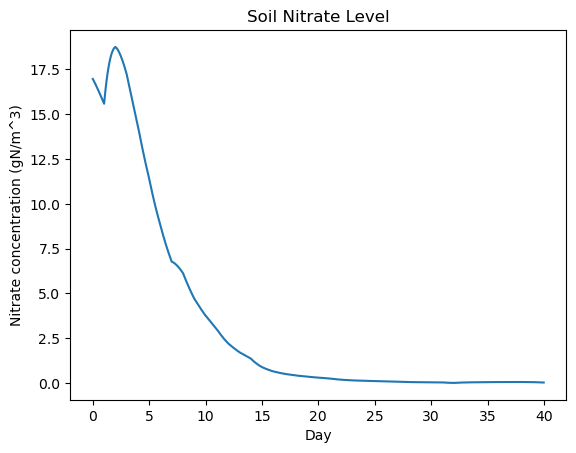

In [147]:
plt.plot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate)
plt.title("Soil Nitrate Level")
plt.xlabel("Day")
plt.ylabel("Nitrate concentration (gN/m^3)")

Text(0, 0.5, 'Ammonium concentration (gN/m^3)')

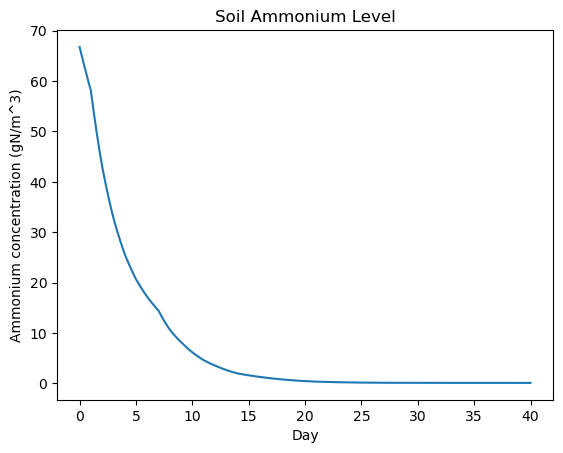

In [148]:
plt.plot(np.arange(len(ammonium)) * INORGANIC_N_MODEL_DT_DAYS, ammonium)
plt.title("Soil Ammonium Level")
plt.xlabel("Day")plt.figure()
plt.title("N Leaching")
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, len(experiment_ammonium_leaching)), experiment_ammonium_leaching, label="ammonium")
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, len(experiment_nitrate_leaching)), experiment_nitrate_leaching, label="nitrate")
plt.xlabel("Day")
plt.ylabel("Leaching rate (gN/m^3/day)")
plt.legend(loc="upper right")
plt.ylabel("Ammonium concentration (gN/m^3)")

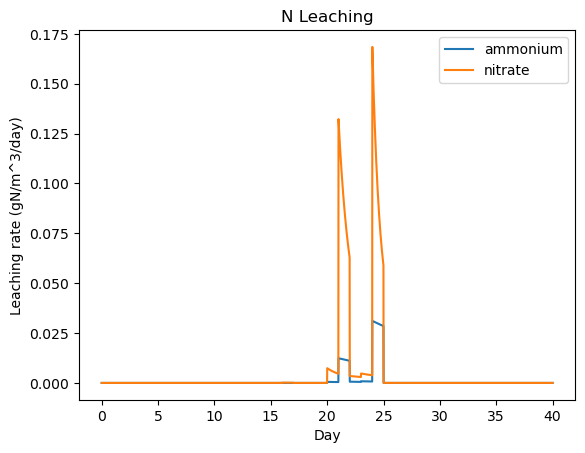

In [151]:
leaching_time_series = np.linspace(0, NUM_DAYS_TOTAL, len(experiment_nitrate_leaching))
leaching_concentration_gN_per_L = np.zeros(experiment_nitrate_leaching.shape)
for large_array_idx in range(len(leaching_time_series) - 1):
    small_array_idx = int(leaching_time_series[large_array_idx])
    if experiment_leakage_mm_per_day[small_array_idx] > 0:
        leaching_concentration_gN_per_L[large_array_idx] = (experiment_nitrate_leaching[large_array_idx] + experiment_ammonium_leaching[large_array_idx]) / experiment_leakage_mm_per_day[small_array_idx]
plt.figure()
plt.title("N Leaching")
plt.plot(leaching_time_series, leaching_concentration_gN_per_L * 1000)
plt.xlabel("Day")
plt.ylabel("Leakage water N concentration (mg/L)")

In [53]:
import pickle

with open('transition_counts.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(transition_counts, f, pickle.HIGHEST_PROTOCOL)
with open('expected_plant_N_deficit.pickle', 'wb') as f:
    pickle.dump(expected_plant_N_deficit_cost_USD, f, pickle.HIGHEST_PROTOCOL)
with open('optimal_cost_to_go_USD_per_m2.pickle', 'wb') as f:
    pickle.dump(optimal_cost_to_go_USD_per_m2, f, pickle.HIGHEST_PROTOCOL)
with open('optimal_nitrate_add_in_cells.pickle', 'wb') as f:
    pickle.dump(optimal_nitrate_add_in_cells, f, pickle.HIGHEST_PROTOCOL)
with open('optimal_ammonium_add_in_cells.pickle', 'wb') as f:
    pickle.dump(optimal_ammonium_add_in_cells, f, pickle.HIGHEST_PROTOCOL)